# Implied Volatility and Volatility Surfaces
This CUATS mini-project focuses on computing the implied volatility of an option and plotting the volatility surface. We will also discuss how one can use volatility surfaces, or values derived from them, in trading strategies. This document also has both mathematical and coding exercises for you to complete as you read through the document (similar to the coding sessions ran during term).

The CUATS mini-projects are intended to be a deeper dive into a topic, so this will be longer and more involved than a typical coding session. If you get stuck on the exercises (and can't progress even after looking at the hints) please go to the GitHub page for this project and ask for help. Also, where possible, the exercises are made such that you should be able to skip one and still make progress until near the end of the document where everything comes together, so it should be possible to skip to the next part if you're waiting for a response to your questions on GitHub.

The general structure of the project is as follows:
1. Imports and Libraries:
    - Setting up a virtual environment for the project
    - The Python libraries needed for the project
1. What is the volatility surface?
    - Black Scholes call prices, parameters involved
    - Definition of the implied volatility, when does it exist?
    - Volatility surfaces
1. Getting options chains data
    - How the yfinance library works, how to get options data from it
    - Creating a function to collate the options chain information into a pandas dataframe
1. Computing the implied volatility
    - Analytical solution / estimate of the implied volatility in special cases
    - The Bisection method
    - The Newton-Raphson method, and extensions of it
    - Brent's method
1. Interpolating and plotting the volatility surface
    - Importance of ensuring our volatility surfaces are arbitrage-free
    - Discussion of parametric models for volatility surfaces
    - Linear interpolation
    - Cubic spline interpolation
    - Plotting the volatility surface
1. Volatility surface terms and properties
    - Qualitative discussion of some features of the volatility surface (skew, smiles, term structure)
    - Typical shapes for these in different markets
1. Extensions
    - Other modifications, improvements and improvements we can make to the project
    - This section will also include some ideas for much more involved bonus extensions
1. Example implementations
    - Some ways one can use volatility surfaces directly in trading strategies.
1. References

# 1 - Imports and Libraries:
This project is intended to be done in Python. There are some Python libraries (and specific versions) one will need to complete it. Setting up a virtual environment for this project is recommended. For further information on setting up a virtual environment:

- [Venv](https://docs.python.org/3/library/venv.html) - a Python module that helps with creating python virtual environments.
- [Managing environments in conda](https://conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html)

For a more detailed explanation of the benefits of virtual environments, see this page - [Python Virtual Environments: A Primer](https://realpython.com/python-virtual-environments-a-primer/). On the GitHub, we've attached some more explicit instructions for setting up a Python virtual environment using Anaconda. For those who are already familiar with virtual environments, the packages needed for the project are:
- Python(3.12.4) - https://www.python.org/downloads/release/python-3124/, we need version 3.12.4 to be compatible with yfinance version 0.2.40.

- NumPy(1.26.4) - https://numpy.org/, a library that provides fast and easy to use arrays. (Install instructions: https://numpy.org/install/)

- SciPy(1.14.0) - https://scipy.org/, a library that provides many useful algorithms and functions. We're mainly using it for some probability/statistics functions. (Install instructions: https://scipy.org/install/)

- yfinance(0.2.40) - https://pypi.org/project/yfinance/, a library that provides easy access to yahoo finance, a great source of free market data (Install instructions: on the pypi page linked. Note: In the future, these may need to be updated further as old versions of yfinance sometimes stop working. If you are unable to find options data, check yfinance version 0.2.40 is the most current version, and if not update to the current one. To update in conda, one may need to use the following: conda install -c conda-forge yfinance=0.2.40=pyhd8ed1ab_0).

- Pandas(2.2.2) - https://pandas.pydata.org/, a library that provides fast DataFrame objects which we'll use for storing data. Plotly and yfinance both use Pandas so using it makes it easier to interface with them. (Install instructions: https://pandas.pydata.org/getting_started.html)

- Plotly(5.22.0) - https://plotly.com/python/, a library that makes producing high quality plots easy. We'll use this for making visualisations of volatility surfaces. (Install instructions: https://plotly.com/python/getting-started/)

- Matplotlib(3.9.1) - https://matplotlib.org/, the standard python plotting library. Only used for a single plot which can't be easily replicated in plotly, so this is optional. (Install instructions: https://matplotlib.org/stable/install/index.html)

- nbformat(5.10.4) - https://pypi.org/project/nbformat/, the base Jupyter notebook format, sometimes the Plotly plots won't show unless this package is installed.

- ipykernel(6.29.5) - https://pypi.org/project/ipykernel/, a package that is needed to run Jupyter Notebooks. For a brief introduction to Jupyter Notebooks, see: https://jupyter.org/try-jupyter/notebooks/?path=notebooks/Intro.ipynb

Standard Python packages we'll use:

- datetime (3.12.4) - https://docs.python.org/3/library/datetime.html, a standard python library that includes useful tools for storing and modifying dates.

- os (optional) - We'll also use the standard Python os library that allows one to save and load files from the directory. This is an optional extra, and isn't necessary for the project. If you're running this notebook on a different platform (for instance Google Colab) you'll need to rewrite the code to match how files are read and written to on that platform.

# 2 - What is the volatility surface?

## 2.1 - The Black-Scholes model
A common method to price options is the Black-Scholes model (though there are others, some of which are discussed in the extension). If we consider an option created at time $t = 0$ it will have the following (widely known) parameters:
- T - the time at which the option expires.
- K - the strike price of the option.
- $S_0$ - the price of the stock at time $t=0$.
- r - the risk-free interest rate available.
Then if we want to know the fair price of an option in the Black-Scholes model at time $t$ the following parameters are relevant:
- t - the current time.
- $\sigma$ - the standard deviation of the stocks returns, also known as the volatility.
- $\mu$ - the drift rate (average rate at which we expect stock prices to increase).

The Black-Scholes price of a call option at time $t$ with strike $K$, underlying price $S_t$ at time $t$ and expiration time $T$ is given by:

$C(S_t,t) = S_t \times \Phi(d_1) - K \times \Phi(d_2) e^{-r(T-t)}$

Where $\Phi$ is the cumulative distribution function of a standard normal random variable and:

$$ d_1 = \frac{1}{\sigma \sqrt{T-t}} \left\{ ln\left(\frac{S_t}{K}\right) + \left(r + \frac{\sigma^2}{2}\right)(T-t)\right\}$$

$$ d_2 =  \frac{1}{\sigma \sqrt{T-t}} \left\{ ln\left(\frac{S_t}{K}\right) + \left(r - \frac{\sigma^2}{2}\right)(T-t)\right\}$$

Alternatively, one can write $d_2 = d_1 - \sigma \sqrt{T-t} $.

For a put option, one can show using put-call parity that the price is:

$$ P(S_t, t) = K \times \Phi(-d_2)e^{-r(T-t)} - S_t \times \Phi(-d_1)$$

The last of our parameters, $\mu$, does not appear in either of the pricing formula. This is because we value options under something called the risk neutral measure. The full explanation of this is quite mathematical, and beyond the scope of this project. A (quite simplified) explanation for why the drift $\mu$ does not feature in the Black-Scholes price is as follows:
- Consider a call option with strike $K=0$. At the expiry time T, this would payout the exact price of the stock at time T, i.e. S_T.
- Therefore, the option pays out exactly the same value as:
    - Buying the stock right now, costing S_t
    - Selling it at time T, paying out S_T
- Therefore, the option should cost exactly the same value as the stocks current value S_t (and there is no drift).
- More generally, if there was some known drift that everyone agreed on, then it should already be priced into the current value of the stock and so doesn't need to be included in the pricing formula.

One may debate whether these assumptions are reasonable. Interest rates are not fixed over time, and there's also strong evidence that volatility is not constant over time. These are simply the assumptions of the Black-Scholes model.

We can now determine the theoretical Black-Scholes price of any option. As the current time $t$, risk-free rate $r$, current price $S_t$, strike price $K$ and expiration date/time $T$ are all known, and as $\mu$ doesn't affect the Black-Scholes price, we can compute the price provided we know the volatility $\sigma$.

## 2.2 - Volatility
From the previous section, if we know the volatility we can compute the (Black-Scholes) price of any given option using the above formulae. The volatility that's important for pricing is the volatility of the underlying asset over the time $[t,T]$. As the current time is $t$, this interval is in the future (so we don't know what it is yet). To remedy this, one can use a range of methods to estimate the future volatility. The simplest way is to use the historical volatility (the standard deviation of the log returns, for further details see [here](https://www.macroption.com/historical-volatility-calculation/)) over some time period.

This method may perform well in some cases, but consider the following:
- Say the underlying asset is stock of company A.
- Company A is a pharmaceutical company that produces drugs, and over the past year they've been working on a promising new drug which would revolutionise the treatment of some widespread disease (and lead to massive profits for the company).
- This drug has a clinical trial in the next three months.

Clearly if the drug trial is successful, company A is more likely to be profitable in the future and so its share price will increase. On the other hand if it is unsuccessful, company A's share price will likely decrease. In either case, we would expect to see a large change in share prices (and so we should price with a higher volatility than the historic volatility would suggest) for an option expiring in a bit over 3 months. Therefore, in this case the realised volatility (the volatility the prices will actually have had over the interval $[t,T]$) may be much higher than historical levels.

## 2.3 - Implied Volatility
To fix these issues, models could be developed for different possible conditions companies are in, and investors will generally buy and sell options based on the volatility they (or their models) think the underlying assets prices will have. Overall, we would expect prices to differ from the prices predicted when using historic volatility in various ways across different assets.

As option prices are increasing and continuous with respect to volatility, we can find (for any parameters of the option) the unique volatility $\sigma_1$ which, when put into the Black-Scholes formula, gives the price we can buy the option for on the market. This volatility $\sigma_1$ is known as the implied volatility (IV) of that option and is the focus of this project. Note that different options can have different strikes and expiration dates and will naturally have different prices. This can lead to (sometimes vastly) different implied volatilities.


## 2.4 - The Volatility Surface
As the implied volatility can be different for different options, one may wish to get a full picture and use all of the data available on the options chain (an options chain is the listing of all option contracts for a particular underlying asset. It's usually split into calls and puts). This gives a better idea of how investors might expect volatility to change over time, and in what ways the stock may be more or less likely to move. As there are many strikes and expiration dates (often well over 100) it is difficult to see this when presented as a table.

Some trading strategies look at a particular portion (i.e. same strike price, different times to expiration, or same expiration date for a range of strikes) to make it easier to spot patterns by focusing on a subset of the data. To see how the implied volatility changes with respect to both the strike price and the time to expiry, one can plot it as a 3D surface with:
- Implied Volatilities as the z axis (generally plots are oriented so the positive z axis is "up")
- Time to maturity as the x axis
- Strike price as the y axis
One can then see the surface and interpret it much more easily at a glance. Our main goal for this project is to make a program that produces plots of a volatility surface for a given underlying asset based on the options chain.

# 3 - Getting Options chains
To produce the volatility surface plot, we need implied volatilities. To get implied volatilities, we need to know the market prices of the options. We will do this using the Python library _yfinance_. This allows us to easily access market data provided freely by [Yahoo Finance](https://uk.finance.yahoo.com/). We will now cover briefly some of the data we can obtain with yfinance.

## 3.1 - Exploring yfinance

In [75]:
import yfinance as yf
import pandas as pd
import datetime
# Checking version of yfinance. We want the most recent version (at time of writing, 0.2.40)
print(yf.__version__)

0.2.66


In [76]:
# First, we set up a yfinance Ticker object for a given ticker:
ticker = "AAPL"
aapl = yf.Ticker(ticker)

# This shows the OHLC data for the most recent 5 trading days, as well as the volume, dividends paid and any stock splits.
aapl.history(period = "5d")

# One can use other periods, i.e. period = "1mo" gives the past month of data.

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2026-02-06 00:00:00-05:00,276.860920,280.647386,276.671095,277.859985,50453400,0.00,0.0
2026-02-09 00:00:00-05:00,277.910004,278.200012,271.700012,274.619995,44623400,0.26,0.0
2026-02-10 00:00:00-05:00,274.890015,275.369995,272.940002,273.679993,34376900,0.00,0.0
2026-02-11 00:00:00-05:00,274.700012,280.179993,274.450012,275.500000,51931300,0.00,0.0
2026-02-12 00:00:00-05:00,275.589996,275.720001,260.179993,261.730011,80867900,0.00,0.0


In [77]:
# We can also get data about stock splits, dividends an other information relating to the stock.

# aapl.actions - information on actions that have occurred (both stock splits and dividends),

# aapl.dividends - just the dividend information

# aapl.splits - just the stock split information.

aapl.actions # Note: there may be no actions in the past 5 days, so this is likely to be empty.

,Dividends,Stock Splits
Date,,
1987-05-11 00:00:00-04:00,0.000536,0.0
1987-06-16 00:00:00-04:00,0.000000,2.0
1987-08-10 00:00:00-04:00,0.000536,0.0
1987-11-17 00:00:00-05:00,0.000714,0.0
1988-02-12 00:00:00-05:00,0.000714,0.0
...,...,...
2025-02-10 00:00:00-05:00,0.250000,0.0
2025-05-12 00:00:00-04:00,0.260000,0.0
2025-08-11 00:00:00-04:00,0.260000,0.0


In [78]:
# To see actions in the past year, we can do:
aapl.history(period = "1y")
aapl.actions

# To get dividends, use aapl.dividends,
# To get splits, use aapl.splits

,Dividends,Stock Splits
Date,,
1987-05-11 00:00:00-04:00,0.000536,0.0
1987-06-16 00:00:00-04:00,0.000000,2.0
1987-08-10 00:00:00-04:00,0.000536,0.0
1987-11-17 00:00:00-05:00,0.000714,0.0
1988-02-12 00:00:00-05:00,0.000714,0.0
...,...,...
2025-02-10 00:00:00-05:00,0.250000,0.0
2025-05-12 00:00:00-04:00,0.260000,0.0
2025-08-11 00:00:00-04:00,0.260000,0.0


In [79]:
# To get metadata about the stock:
aapl.history_metadata

{'currency': 'USD',
 'symbol': 'AAPL',
 'exchangeName': 'NMS',
 'fullExchangeName': 'NasdaqGS',
 'instrumentType': 'EQUITY',
 'firstTradeDate': 345479400,
 'regularMarketTime': 1770930002,
 'hasPrePostMarketData': True,
 'gmtoffset': -18000,
 'timezone': 'EST',
 'exchangeTimezoneName': 'America/New_York',
 'regularMarketPrice': 261.73,
 'fiftyTwoWeekHigh': 288.62,
 'fiftyTwoWeekLow': 169.21,
 'regularMarketDayHigh': 275.72,
 'regularMarketDayLow': 260.18,
 'regularMarketVolume': 71430852,
 'longName': 'Apple Inc.',
 'shortName': 'Apple Inc.',
 'chartPreviousClose': 278.12,
 'previousClose': 275.5,
 'scale': 3,
 'priceHint': 2,
 'currentTradingPeriod': {'pre': {'timezone': 'EST',
   'start': 1770973200,
   'end': 1770993000,
   'gmtoffset': -18000},
  'regular': {'timezone': 'EST',
   'start': 1770993000,
   'end': 1771016400,
   'gmtoffset': -18000},
  'post': {'timezone': 'EST',
   'start': 1771016400,
   'end': 1771030800,
   'gmtoffset': -18000}},
 'tradingPeriods':                 

In [80]:
# We can also get data about the current major holders of the stock:
aapl.institutional_holders # major institutional holders

# Lastly, one can get recent news articles relating to the stock with .news
aapl.news

[{'id': '90f51309-e44e-4409-b74f-822cdc024056',
  'content': {'id': '90f51309-e44e-4409-b74f-822cdc024056',
   'contentType': 'STORY',
   'title': 'Stock market today: Dow, S&P 500, Nasdaq sink as tech gets hit as AI disruption fears grow; gold, bitcoin sink',
   'description': '',
   'summary': "Wall Street is gearing up for an update on the Fed's favored inflation gauge, after the jobs report bolstered the case for keeping rates unchanged.",
   'pubDate': '2026-02-12T21:03:53Z',
   'displayTime': '2026-02-13T00:58:20Z',
   'isHosted': True,
   'bypassModal': False,
   'previewUrl': None,
   'thumbnail': {'originalUrl': 'https://s.yimg.com/os/creatr-uploaded-images/2026-02/af29bcc0-078c-11f1-b0f6-2f95b0cfedb7',
    'originalWidth': 4040,
    'originalHeight': 2694,
    'caption': '',
    'resolutions': [{'url': 'https://s.yimg.com/uu/api/res/1.2/ywuKJdFDLlSIydBvgyRvBg--~B/aD0yNjk0O3c9NDA0MDthcHBpZD15dGFjaHlvbg--/https://s.yimg.com/os/creatr-uploaded-images/2026-02/af29bcc0-078c-11f1-b

Now that we've covered some basic functionality of yfinance, we will move on to the main part we need for this project, getting options chain data. _aapl.options_ gives the expiry dates of AAPL options that yfinance has data for. We can then get an option chain for a specific expiry date using the _.option_chain()_ function, which takes as input the expiry date we're interested in getting the option chain for.

We want to get all the data yfinance has, so we will loop over all the expiry dates it has information for and get the option chain.

In [81]:
# Exploration
expiry_dates = aapl.options
print(expiry_dates[0])
first_option_chain = aapl.option_chain(expiry_dates[0])

2026-02-13


This option chain is a tuple object, with entries:

_(call_data_frame, put_data_frame, general_information_dictionary)_

we can access each of these with first_option_chain[i] for different values of i.


In [82]:
# To access the call part of the data, we can use
first_option_chain[0].head(5)
# or
first_option_chain.calls[20:30]
# (And similarly for the puts).

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
20,AAPL260213C00242500,2026-02-12 17:55:02+00:00,242.5,19.90,0.0,0.0,0.0,0.0,6.0,70,0.000010,True,REGULAR,USD
21,AAPL260213C00245000,2026-02-12 20:54:52+00:00,245.0,17.50,0.0,0.0,0.0,0.0,159.0,360,0.000010,True,REGULAR,USD
22,AAPL260213C00247500,2026-02-12 14:52:47+00:00,247.5,25.10,0.0,0.0,0.0,0.0,1.0,55,0.000010,True,REGULAR,USD
23,AAPL260213C00250000,2026-02-12 20:59:28+00:00,250.0,12.60,0.0,0.0,0.0,0.0,374.0,3822,0.000010,True,REGULAR,USD
24,AAPL260213C00252500,2026-02-12 20:59:41+00:00,252.5,10.00,0.0,0.0,0.0,0.0,55.0,413,0.000010,True,REGULAR,USD
25,AAPL260213C00255000,2026-02-12 20:56:28+00:00,255.0,7.55,0.0,0.0,0.0,0.0,1006.0,1112,0.000010,True,REGULAR,USD
26,AAPL260213C00257500,2026-02-12 20:57:50+00:00,257.5,5.50,0.0,0.0,0.0,0.0,960.0,628,0.000010,True,REGULAR,USD
27,AAPL260213C00260000,2026-02-12 20:59:58+00:00,260.0,3.35,0.0,0.0,0.0,0.0,8723.0,3168,0.000010,True,REGULAR,USD
28,AAPL260213C00262500,2026-02-12 20:59:59+00:00,262.5,2.02,0.0,0.0,0.0,0.0,26779.0,5233,0.015635,False,REGULAR,USD
29,AAPL260213C00265000,2026-02-12 20:59:58+00:00,265.0,1.05,0.0,0.0,0.0,0.0,45484.0,11541,0.062509,False,REGULAR,USD


To confirm everything is functioning as intended, we can compare these values to an alternative data source. We check our prices against the Nasdaq website's AAPL option chain data, which can be found [here](https://www.nasdaq.com/market-activity/stocks/aapl/option-chain). We can see that the most recent prices are the same, and the dates / times to expiry also match up, confirming that the yfinance data is accurate.

In [83]:
# Creating a boolean variable for whether an option is a put or a call:
call_df = first_option_chain.calls
put_df = first_option_chain.puts
call_df["call"] = True
put_df["call"] = False

# Combining the options chains dataframes into one:
full_chain_data = pd.concat([call_df, put_df])

# Converting the date into a datetime object so we can modify it, and then storing it in our dataframe:
full_chain_data["Expiration"] = pd.to_datetime(expiry_dates[1])

# Saving the number of days until it expires:
full_chain_data["DTE"] = (full_chain_data["Expiration"] - datetime.datetime.today()).dt.days + 1
# Note: DTE is the number of days until expiry, but .dt.days only includes the whole number of days until expiry.
# Therefore, if we don't add the 1:
# if the current day is the 5th, and the option expires on the 10th there are 4 whole days until expiry
# (and some portion of another day) so DTE is set to 4. It makes more sense for this to be set to 5 instead.

# Checking the results:
full_chain_data[["DTE", "Expiration"]].head(5)

,DTE,Expiration
0,5,2026-02-18
1,5,2026-02-18
2,5,2026-02-18
3,5,2026-02-18
4,5,2026-02-18


In [84]:
options_data = pd.DataFrame()
for expiry in expiry_dates:
    # Getting the option chain for the current expiry
    current_option_chain = aapl.option_chain(expiry)
    call_df = current_option_chain.calls
    put_df = current_option_chain.puts
    call_df["call"] = True
    put_df["call"] = False

    # Reformatting it to be a single data frame:
    current_option_chain = pd.concat([call_df, put_df])
    current_option_chain["Expiration"] = pd.to_datetime(expiry)
    # current_option_chain["DTE"] = (full_chain_data["Expiration"] - datetime.datetime.today()).dt.days
    options_data = pd.concat([options_data, current_option_chain])

options_data["DTE"] = (options_data["Expiration"] - datetime.datetime.today()).dt.days
# Note: DTE is the number of whole days until expiry. For instance, if the current day is the 5th, and the option expires on the 10th,
# there are 4 whole days until expiry (and some portion of another day) so DTE is set to 4.

# Lastly, we remove some columns we no longer need:
options_data = options_data.drop(columns = ["contractSize","currency","percentChange"])

## 3.2 - A function to gather options chains
We may need to gather this option chain data for different tickers, so it makes sense to make our code into a function we can call to retrieve the full data frame of options data.

Exercise 1:


In [85]:
def get_options_data(ticker):
    # A function that takes as input a string corresponding to a stock ticker, and outputs a dataframe containing
    # all of the yfinance options data for that ticker.

    # Getting the ticker object and the dates to loop over
    yf_ticker = yf.Ticker(ticker)
    expiry_dates = yf_ticker.options

    # Container to store the data.
    options_data = pd.DataFrame()

    for expiry in expiry_dates:

        chain = yf_ticker.option_chain(expiry)

        calls = chain.calls
        puts = chain.puts

        calls['call'] = True
        puts['call'] = False

        chain_df = pd.concat([calls, puts])

        chain_df['Expiration'] = pd.to_datetime(expiry)

        options_data = pd.concat([options_data, chain_df], ignore_index=True)

    options_data["DTE"] = (options_data["Expiration"] - datetime.datetime.today()).dt.days + 1 # We add one as dt.days rounds down
    options_data = options_data.drop(columns = ["contractSize","currency","percentChange"])
    return(options_data)

In [86]:
# Testing our code works:
aapl_df = get_options_data("AAPL")
aapl_df

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,volume,openInterest,impliedVolatility,inTheMoney,call,Expiration,DTE
0,AAPL260213C00110000,2026-02-12 16:54:41+00:00,110.0,155.21,0.0,0.0,0.0,1.0,3,0.00001,True,True,2026-02-13,0
1,AAPL260213C00120000,2026-02-03 14:50:41+00:00,120.0,149.55,0.0,0.0,0.0,NaN,0,0.00001,True,True,2026-02-13,0
2,AAPL260213C00140000,2026-02-04 15:02:55+00:00,140.0,136.17,0.0,0.0,0.0,1.0,0,0.00001,True,True,2026-02-13,0
3,AAPL260213C00150000,2026-01-30 20:30:54+00:00,150.0,110.00,0.0,0.0,0.0,2.0,0,0.00001,True,True,2026-02-13,0
4,AAPL260213C00160000,2026-02-03 17:17:22+00:00,160.0,109.18,0.0,0.0,0.0,4.0,0,0.00001,True,True,2026-02-13,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2599,AAPL281215P00360000,2026-02-09 14:53:03+00:00,360.0,92.91,0.0,0.0,0.0,1.0,11,0.00001,True,False,2028-12-15,1036
2600,AAPL281215P00370000,2026-02-05 20:25:42+00:00,370.0,98.95,0.0,0.0,0.0,10.0,3,0.00001,True,False,2028-12-15,1036
2601,AAPL281215P00380000,2026-02-12 20:08:25+00:00,380.0,118.80,0.0,0.0,0.0,2.0,6,0.00001,True,False,2028-12-15,1036
2602,AAPL281215P00400000,2026-01-29 17:45:40+00:00,400.0,143.06,0.0,0.0,0.0,NaN,0,0.00001,True,False,2028-12-15,1036


# 4 - Computing the Implied Volatility

## 4.1 - Motivation
As discussed in Part 1, now that we have the options data we need to compute the implied volatility. If you were looking closely in the previous few sections, you may have noticed that yfinance reports the implied volatility of the options. One could simply use this to plot the volatility surface and skip this section entirely. However:
- What if you wanted to plot the volatility surface when using a different pricing model (e.g. the Bachelier model - see the extensions)?
- What if you needed to get a fast, approximate value for an implied volatility?
- What if the provider in a particular market didn't give implied volatilities for the assets you wished to trade with?
- How are you sure the providers implied volatilities are correct?

and of course, the process of computing implied volatilities is quite interesting. It's a relatively simple problem to understand, but there are many different approaches to get accurate and fast estimates of the implied volatility.

In Part 1 we noted that:
1. The implied volatility $\sigma_1$ is the volatility such that the Black-Scholes price of the option is equal to the current market price
2. The Black-Scholes price of an option is continuous and increasing as the volatility changes (when the other parameters are fixed).
therefore, if we write $f(\sigma)$ as the Black-Scholes price of an option with time $t$ price $S_t$, strike $K$, expiration time/date $T$, risk-free rate $r$ and volatility $\sigma$, the implied volatility $\sigma_1$ is the (unique from 2.) value such that $f(\sigma_1) = V$ where $V$ is the market price of the option.

In other words, we have to solve for the root $\sigma_1$ of the equation $f(\sigma)-V$. We will cover a few methods to do this.


## 4.2 - Analytic solution:
Unfortunately, there is no known closed form solution to this problem in the general case, as there is no known way to invert the function $f$
$$f(\sigma) = S_t \times \Phi(d_1(\sigma)) - K \times \Phi(d_2(\sigma)) e^{-r(T-t)}$$
where $\Phi$ is the cumulative distribution function of a standard normal random variable and:

$$ d_1 = \frac{1}{\sigma \sqrt{T-t}} \left\{ ln\left(\frac{S_t}{K}\right) + \left(r + \frac{\sigma^2}{2}\right)(T-t)\right\}$$

$$ d_2 =  \frac{1}{\sigma \sqrt{T-t}} \left\{ ln\left(\frac{S_t}{K}\right) + \left(r - \frac{\sigma^2}{2}\right)(T-t)\right\}$$

Now we don't have a closed form for $\Phi^{-1}$ either, which poses an issue. If a loss in accuracy is acceptable, one can use a Taylor expansion on $\Phi$ and determine a fully closed form approximation to the implied volatility that works for small values of $\sigma \sqrt{T-t}$ and is very simple.

---(SPOLIERS FOR EXERCISE 1 AHEAD)---


### 4.2.1 - Analytical approximation of IV (for ATM options)
We have $S = K e^{-r(T-t)}$ so, using the same approach as in Exercise 1, we can simplify our expressions for $d_1$ and $d_2$ to get $d_1(\sigma) = \sigma/2* \sqrt{T-t}$ and $d_2(\sigma) = -\sigma/2* \sqrt{T-t}$. Then our expression for the call price becomes:

$$C(S_t,t) = \Phi(d_1) S - \Phi(d_2) K e^{-r(T-t)} = \Phi(\sigma/2* \sqrt{T-t}) S - \Phi(-\sigma/2* \sqrt{T-t}) K e^{-r(T-t)} $$

To deal with $\Phi$, which we cannot analyitcally invert, we will assume that $\sigma/2* \sqrt{T-t}$ is small enough that a Taylor expansion of $\Phi$ around $0$ is valid. We note that:
- $\Phi(0) = 1/2$
- $\Phi'(x) = \frac{1}{\sqrt{2\pi}} e^{-x^2/2}$ and substituting in $0$ we get $\Phi'(0) = \frac{1}{\sqrt{2\pi}}$
- $\Phi''(x) = \frac{1}{\sqrt{2\pi}} \times -xe^{-x^2/2}$ and substituting in 0 we get $\Phi''(0) = 0$

Taylor's formula applied to $\Phi$ gives that for $x$ near $0$:

$$\Phi(x) = \Phi(0) + x \Phi'(0) + \frac{x^2}{2} \Phi''(0) + O(x^3) = 0.5 + \frac{1}{\sqrt{2\pi}} x + 0 + O(x^3)$$

We now apply this to our expression for the call price and get:

$$C(S_t, t) \approx \frac{S}{2} + \frac{S\sigma \sqrt{T-t}}{2*\sqrt{2\pi}} - \frac{Ke^{-r(T-t)}}{2} + \frac{Ke^{-r(T-t)} \sigma\sqrt{T-t}}{2*\sqrt{2\pi}}$$

And now applying $S = K e^{-r(T-t)}$ gives:

$$C(S_t, t) \approx \frac{S\sigma \sqrt{T-t}}{2*\sqrt{2\pi}}  + \frac{S \sigma\sqrt{T-t}}{2*\sqrt{2\pi}} =\frac{S \sigma\sqrt{T-t}}{\sqrt{2\pi}}$$

Rearranging for $\sigma$ gives:

$$\sigma \approx \sqrt{\frac{2\pi}{T-t}} \frac{C}{S}$$

For computing this in your head or on paper, note that $\sqrt{2\pi} \approx 2.5$, so we get a loose approximation of the IV of: $2.5 \times \frac{\text{option price}}{\text{stock price} \times \text{sqrt(time to expiry)}}$

This approximation was first derived by Brenner and Subrahmanyam in 1988. Corrado and Miller expanded this to cover when stock prices deviate from discounted strikes in 1996, and more recently even more accurate approximations have been discovered.

## 4.3 - Numerical Methods
In the general it is not at all clear how to invert $f$ and find a exact closed form expression for $\sigma$ in terms of $V$. We will instead attempt to find a numerical approximation to this problem.

We will consider the following root finding algorithms:
- The bisection method (a reliable but slow method)
- The Newton-Raphson method (and an extension to it)
- Brent's method (a widely used root finding algorithm)

These can all be applied generally to other problems where one needs to find the zeros of a (sufficiently well behaved) function.


### 4.3.1 - Getting the price for a given volatility
On top of there not being a closed form solution, we have another issue. $\Phi$, the CDF of a $N(0,1)$ random variable, is given by:

$$ \Phi(x) = \int_{-\infty}^x e^{-u^2/2}du$$

This is problematic because the right hand side is an integral, not a combination of analytic functions. This means that to get values of $\Phi$ we either need to:
- Use some sort of integration method to compute values of $\Phi$.
- Use some approximation of the true value of $\Phi$ derived mathematically.

For those interested in approximations to the normal CDF, a paper providing a good overview and a practical approach to accurate approximations to the normal CDF can be found here: [Approximating the cumulative distribution function of the normal distribution](http://jsr.isrt.ac.bd/wp-content/uploads/41n1_5.pdf).

In the name of conciseness, we will use the SciPy normal CDF, which approximates $\Phi$ to a high accuracy. It relies upon the Cephes Math Library's implementation of the inverse of the logarithm of the CDF of the standard normal distribution. To get this cdf, we use the following code:

In [87]:
from scipy.stats import norm

# Setting up plotly for plotting in a Jupyter Notebook
import plotly.graph_objects as go

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import numpy as np
Phi = norm.cdf
x = np.linspace(-6,6, 100)
y = Phi(x)
y[1:5]

array([2.06640782e-09, 4.26652390e-09, 8.68392215e-09, 1.74239803e-08])

In [88]:

fig = go.Figure(data = go.Scatter(x=x, y=Phi(x)))
fig.update_layout(title="Graph of Phi, the standard normal CDF",
                  yaxis_title = "Phi(x)",
                  xaxis_title = "x")
iplot(fig)

And for the derivative of the Black-Scholes price with respect to $\sigma$ (which we'll need for some of the methods) there is a nice closed form which can be written in terms of the pdf of a N(0,1) random variable.

In [89]:
deriv_Phi = norm.pdf
print(f"SciPy implementation: {deriv_Phi(0.1)}")
print(f"Test implementation: {1/np.sqrt(2*np.pi)* np.exp(-0.5 * 0.1**2)}")

SciPy implementation: 0.3969525474770118
Test implementation: 0.3969525474770118


Now we need to actually code the Black-Scholes price (and it's derivative) so we can call them for root finding methods.

Exercise 2:

In [90]:
def black_scholes_call_price(vol, time_to_expiry, strike_price, current_price, risk_free):
    d_1 = 1/vol * 1/np.sqrt(time_to_expiry) * (np.log(current_price/strike_price) + (risk_free + vol**2/2) * time_to_expiry)
    d_2 = d_1 - vol * np.sqrt(time_to_expiry)
    term_1 = current_price * Phi(d_1)
    term_2 = strike_price * np.exp(-risk_free * time_to_expiry) * Phi(d_2)
    return term_1 - term_2


def black_scholes_put_price(vol, time_to_expiry, strike_price, current_price, risk_free):

    d_1 = 1/vol * 1/np.sqrt(time_to_expiry) * (np.log(current_price/strike_price) + (risk_free + vol**2/2) * time_to_expiry)
    d_2 = d_1 - vol * np.sqrt(time_to_expiry)

    # Fórmula del Put: K * e^(-rT) * Phi(-d2) - S * Phi(-d1)
    # Note: Asumo que Phi() es la CDF normal estándar definida previamente en tu notebook
    term_1 = strike_price * np.exp(-risk_free * time_to_expiry) * Phi(-d_2)
    term_2 = current_price * Phi(-d_1)

    return term_1 - term_2


In [91]:
# Test your implementation
vol = np.array([0.1,0.55,1,2.5]) #0.55 here corresponds to 55% volatility
time_to_expiry = np.array([5,4,3,2]) # in years
strike_price = np.array([20,22.5,25,27.5]) # £ or $
current_price = 10 # $ or £
risk_free = 0.04 # 0.04 corresponds to 4% per year

prices = black_scholes_put_price(vol, time_to_expiry, strike_price, current_price, risk_free)
print(prices)
# If everything is working this should be small (on the order of 10^-6). If not, check your function is correct.
np.max(np.abs(prices - np.array([6.38831,11.57596,16.70026,24.18715])))

[ 6.38831505 11.5759621  16.70025843 24.18714364]


np.float64(6.3642237613237285e-06)

We also need to implement the derivative with respect to the volatility:

In [92]:
def black_scholes_derivative(vol, time_to_expiry, strike_price, current_price, risk_free):
    d_1 = 1/vol * 1/np.sqrt(time_to_expiry) * (np.log(current_price/strike_price) + (risk_free + vol**2/2) * time_to_expiry)
    derivative = current_price * deriv_Phi(d_1) * np.sqrt(time_to_expiry)
    return(derivative)

In [93]:
derivs = black_scholes_derivative(vol, time_to_expiry, strike_price, 30, risk_free)

# This is also around 10^-6
np.max(np.abs(derivs - np.array([0.50264,15.14238,12.06334,3.25995])))

np.float64(4.683155655271776e-06)

Now that we have functions to evaluate the Black-Scholes price, and it's derivative with respect to volatility, we are ready to discuss the root finding methods.

### 4.3.2 - The bisection method

As the price is continuous and increasing with respect to the volatility, if we can find $\sigma^{(0)}_- < \sigma^{(0)}_+$ such that:

$$f(\sigma^{(0)}_-)-V < 0 \quad \text{and} \quad f(\sigma^{(0)}_+)-V > 0$$

then we know that the unique implied volatility is in the interval $[\sigma^{(0)}_- , \sigma^{(0)}_+]$. Next, we can pick a point in this interval, $\sigma_1$, and check whether $f(\sigma_1)-V$ is positive or negative. If it is positive, then similarly to the above we know the implied volatility is in the interval $[\sigma^{(1)}_- , \sigma^{(1)}_+]$ where:

$$\sigma^{(1)}_- = \sigma^{(0)}_-,\quad \sigma^{(1)}_+ = \sigma_1$$

Similarly, if it is negative then we know the implied volatility is in the interval $[\sigma^{(1)}_- , \sigma^{(1)}_+]$ where this time:

$$\sigma^{(1)}_- = \sigma_1, \quad \sigma^{(1)}_+ = \sigma^{(0)}_+$$

To minimize the size of this range in the worst case, we can choose $\sigma_i$ to be the midpoint of the previous interval, so:

$$\sigma_{i+1} = \frac{\sigma^{(i)}_+ + \sigma^{(i)}_-}{2}$$

Then, to find the root, we repeatedly apply this process, at each step defining $\sigma_i$ as the midpoint and determining which interval to continue searching in using the same steps as above. Now we will implement this in code. The version we implement is slightly more general, as it works for both decreasing and increasing continuous functions.

In [94]:
def bisection_with_width(FUN, init_lower, init_upper, target_value, width):

    # A function that computes the input value x such that FUN(x) = target_value via a binary search.
    # (solution is accurate up to some acceptable width).

    # Method is guaranteed to work if the init_lower < true root < init_upper, and the function is continuous.

    # Counter to track how many iterations it completes:
    counter = 0

    # Error detection
    if (FUN(init_lower)-target_value) * (FUN(init_upper)-target_value)>0:
        return("No change of sign in interval")

    # Running until the interval is within the width specified
    while init_upper - init_lower > width:
        midpoint = (init_lower + init_upper)/2
        # Check which half of the interval the root is in
        if (FUN(init_lower)-target_value)* (FUN(midpoint)-target_value)<0:
            init_upper = midpoint
        else:
            init_lower = midpoint
        counter+=1

    # |midpoint -init_lower| < 0.5*width (and similarly for init_upper) therefore must be a root in the interval
    # (midpoint - 0.5*width, midpoint + 0.5*width)
    midpoint = (init_lower + init_upper)/2
    return(midpoint, counter)

Now we test our function to ensure it's working as intended

In [95]:
def example_polynomial(x):
    return(100*x**5 - 4*x**3 + x-1)

init_lower = 0
init_upper = 100
target_value = 13.5
acceptable_error = 1e-5
root, iterations = bisection_with_width(example_polynomial,init_lower, init_upper, target_value, acceptable_error)
print(f"Using {iterations} iterations, the bisection method found an estimate of the root: {root} accurate up to {acceptable_error}")

Using 24 iterations, the bisection method found an estimate of the root: 0.6851762533187866 accurate up to 1e-05


In [96]:
# Checking that this is a root:
example_polynomial(root) - target_value
# this is small so our code is working.

-0.0002910195599152843

One modification that can be made is to have the tolerance instead apply to the value of the function, ensuring that $|f(x) - V|<\epsilon$ for some tolerance $\epsilon$. This can be more useful than the form above as we can specify how large errors are allowed to be.

Exercise 3:

In [97]:
def bisection_method(FUN, init_lower, init_upper, target_value, tol, max_iterations=250):

    # A function that computes the input value x such that |FUN(x) - target_value|<tol using a binary search.

    # Method is guaranteed to work eventually if the init_lower < true root < init_upper, and the function is continuous.
    counter = 0
    # Error detection
    if (FUN(init_lower)-target_value) * (FUN(init_upper)-target_value)>0:
        return("No change of sign in interval")

    # Running until it reaches the maximum number of iterations or until the function's value is within tol of the target.
    midpoint = (init_lower + init_upper)/2

    while counter < max_iterations:
        val_mid = FUN(midpoint)

        if abs(val_mid - target_value) < tol:
            break

        if (FUN(init_lower) - target_value) * (val_mid - target_value) < 0:
            init_upper = midpoint
        else:
            init_lower = midpoint

        midpoint = (init_lower + init_upper) / 2
        counter += 1

    return(midpoint, counter)

Test your function with the following code:

In [98]:
init_lower = 0
init_upper = 100
target_value = 13.49546
max_iterations = 50
# With these values, the method should converge in <40 steps for each value of i.
for i in range(8):
    acceptable_error = 10**(-1-i)
    root, iterations = bisection_method(example_polynomial,init_lower, init_upper, target_value, acceptable_error)
    if abs(example_polynomial(root) - target_value) < acceptable_error:
        print(f"Error less than 10^({-1-i}) achieved in {iterations} steps")
    else:
        print(f"Method failed to converge in {max_iterations} steps")

Error less than 10^(-1) achieved in 15 steps
Error less than 10^(-2) achieved in 15 steps
Error less than 10^(-3) achieved in 21 steps
Error less than 10^(-4) achieved in 25 steps
Error less than 10^(-5) achieved in 25 steps
Error less than 10^(-6) achieved in 31 steps
Error less than 10^(-7) achieved in 34 steps
Error less than 10^(-8) achieved in 38 steps


In typical markets, implied volatilities are rarely much larger than 100% per month, and are always non negative. One could therefore use initial lower and upper bounds of, for instance, 0 and 1000% for the bisection method, and have a reliable (but rather slow) way to compute implied volatilities.

### 4.3.3 - The Newton-Raphson method

This method is slightly more mathematically involved than the bisection method, and each step takes a bit longer to compute. However, it should (under the right conditions) converge much faster than the bisection method, and overall get a good estimate of the root more quickly.

Given a point $x_i$, the method uses both the functions value and it's gradient at that point to determine a good next point $x_{i+1}$. More specifically, $x_{i+1}$ is given by:

$$x_{i+1} = x_i - \frac{f(x_i)}{f'(x_i)}$$

Then we have that (under the right conditions) $x_n \to y$ where $y$ is such that $f(y) = 0$.

To use this, we of course need to be able to quickly compute the derivative (or some estimate of it) at a point. In exercise 1 we computed the derivative of the B.S. price with respect to volatility, so we know what this function is exactly and so can use the method.

#### Implementing the Newton-Raphson method:
Now, we implement the Newton-Raphson method in code so we can use it for finding roots. We will make a version where one can implement a target value $V$ that it tries to solve for, so we aim to find a sequence of points $x_1, x_2,...$ with $x_n \to y$ where $f(y) = V$.

In [99]:
def newton_raphson(FUN, deriv_FUN, init_point, target_value, tol, max_iterations=250):
    current_point = init_point
    counter = 0
    function_val = FUN(current_point) - target_value
    while counter < max_iterations and abs(function_val) > tol:
        function_val = FUN(current_point) - target_value
        deriv_val = deriv_FUN(current_point)
        current_point = current_point - function_val / deriv_val
        counter +=1
    return(current_point, counter)

Now we run the same test as we did for the bisection method. As this method has more computations, we hope that it converges in fewer steps (and so overall runs faster).

In [100]:
def example_poly_derivative(x):
    return(500*x**4 - 12*x**2 +1)


init_point = 100
target_value = 13.49546
max_iterations = 35
# With these values, the method should converge in <30 steps for each value of i.
for i in range(8):
    acceptable_error = 10**(-1-i)
    root, iterations = newton_raphson(example_polynomial,example_poly_derivative,init_point, target_value, acceptable_error)
    if abs(example_polynomial(root) - target_value) < acceptable_error:
        print(f"Error less than 10^({-1-i}) achieved in {iterations} steps")
    else:
        print(f"Method failed to converge in {max_iterations} steps")

Error less than 10^(-1) achieved in 26 steps
Error less than 10^(-2) achieved in 26 steps
Error less than 10^(-3) achieved in 27 steps
Error less than 10^(-4) achieved in 27 steps
Error less than 10^(-5) achieved in 27 steps
Error less than 10^(-6) achieved in 27 steps
Error less than 10^(-7) achieved in 27 steps
Error less than 10^(-8) achieved in 28 steps


From this output, we see that to get within 10^(-1) took 26 steps, but it only took two more steps to get to less than 10^(-8). This demonstrates one of the key properties of the Newton Raphson method; When started from a point far from the correct root:
- It may move towards the root slowly, taking much longer to get near the true value than other solutions.
- It may oscillate between over and under estimating the root for a long period of time.
- Even worse, these oscillations may even get larger with each iteration, with x_n shooting off to +- infinity.

However, if the method is initialized near the correct value it can converge very quickly, with the number of correct digits in the decimal expansion of $x_n$ roughly doubling at each step. Thus, one common way to use NR is to get a relatively accurate guess of where the root(s) are and then apply NR one or two times to reduce the error to whatever level is necessary.

### 4.3.4 - Drawbacks of the Netwton-Raphson method for Black Scholes prices:
Now we look at some of the drawbacks of the NR method that are relevant to Black-Scholes prices:
- We can only compute numerical estimates of the Black-Scholes price, and these rely on $\Phi$. SciPy's normal CDF is only so accurate, as can be seen by the fact that norm.cdf(10) == norm.cdf(9) evaluates to TRUE, i.e. it cannot distinguish these from one another. For this reason, one generally tries to avoid computing implied volatilities with large $d_1$ values (i.e. deeply in the money options). Instead, one can compute the implied volatility mostly with near the money or out of the money options, where $d_1$ is smaller / negative. norm.cdf(-10) != norm.cdf(-9), so we still have some precision when evaluating the function here.
- The Black-Scholes price, when considered only as a function of $\sigma$, is concave for small $\sigma$ and convex for large $\sigma$. This is problematic because our estimates can overshoot the true value (sometimes by large amounts) and lead to it taking lots of steps to converge or to it diverging completely. We will illustrate this problem with the NR method by applying it to another function.
- Even when the method does converge, it can take many iterations to get "near" the root before it starts to converge quickly (so it would help to have some sensible initial guess).

We will now illustrate the second of these drawbacks on the function $f(x) = tanh(x) = \frac{e^{x} - e^{-x}}{e^{x}+e^{-x}}$. To do so, we will use a way to plot the iterations of the Newton Raphson method.

In [101]:
# By definition
def tanh(x):
    e_to_pos_x = np.exp(x)
    e_to_neg_x = np.exp(-x)
    numerator = e_to_pos_x-e_to_neg_x
    denominator = e_to_pos_x+e_to_neg_x
    return numerator/denominator

# Can show by some fairly trivial algebra
def deriv_tanh(x):
    e_to_pos_x = np.exp(x)
    e_to_neg_x = np.exp(-x)
    numerator = 4
    denominator = (e_to_pos_x+e_to_neg_x)**2
    return numerator/denominator


# The true root (for a target value of 0) is 0. To show the behaviour, we start with a point a bit larger than 1
init_point = 1.15
iterations = 3

# Running the NR method and saving the points:
current_point = init_point
iterates = [init_point]*(iterations+1)
for i in range(iterations):
    function_val = tanh(current_point)
    deriv_val = deriv_tanh(current_point)
    current_point = current_point - function_val / deriv_val
    iterates[i+1] = current_point
print(iterates)

[1.15, np.float64(-1.3184809027729782), np.float64(2.156297840091922), np.float64(-16.49884338674215)]


In [102]:
# Plotting iterates of the NR method:
x_range = 20
x_vals = np.linspace(-x_range,x_range, 500)
tanh_vals = tanh(x_vals)
NR_plot_function_curve = [go.Scatter(x=x_vals, y=tanh_vals, line = dict(color="red"), name="tanh(x)")]
layout_NR_plot=  go.Layout(title = go.layout.Title(text="Newton Raphson applied to tanh(x)"),
                           xaxis = {"title": "x", "range":[-x_range,x_range]})

# Some code to generate the iterates plots, showing the tangent lines
NR_plot_tangents = [
    go.Scatter(x=[iterates[i],iterates[i+1]],
               y=[tanh(iterates[i]),0],
               line=dict(color="blue"),
               name="Tangent",
               legendgroup="Tangent",
               showlegend=(i==0))  # Only show on legend once
    for i in range(iterations)
]

# Code to generate the vertical lines
NR_plot_function_evaluations = [
    go.Scatter(x=[iterates[i],iterates[i]],
               y=[0,tanh(iterates[i])],
               line=dict(color="green"),
               name="Function evaluations",
               legendgroup = "Function evaluations",
               showlegend = (i==0))
    for i in range(iterations+1)
]

NR_plot_x_axis = [go.Scatter(x=[-x_range-5, x_range+5], y=[0,0], line = dict(color = "black"),showlegend=False)]

NR_plot_objects = NR_plot_tangents + NR_plot_function_evaluations + NR_plot_function_curve + NR_plot_x_axis
go.Figure(data=NR_plot_objects,layout = layout_NR_plot)

From this plot, one can see that for our starting value of 1.15, the fact the function is convex for x less than the root and concave for x greater than the root mean that, when we start far from x, our estimates overshoot. Furthermore, they overshoot and increase in magnitude (from 1.15 to -1.318 to 2.156 et cetera). The next step after -16.499 is at x = 53,536,908,600,954 (53 trillion) which is extremely far from the root.

The shape of the Black-Scholes price is somewhat similar to this function, but perhaps slightly better behaved as it's less common for errors to grow over time. Still, in some cases if the initial guess is far too low, it overshoots to extremely large values and takes a while to converge, or reaches a negative value (which is clearly incorrect as the volatility is non negative).

One way to handle this is to use a hybrid of the bisection method and the Newton-Raphson method. The basic idea is to start with some (possibly quite large) interval containing the root, then to compute the next point of the NR method from the current best estimate (initially the midpoint, but if NR performs well then the previous NR iterate). If this next point is outside of the interval (i.e. Newton-Raphson overshoots) or is otherwise not converging quickly enough, it uses the bisection method. If not, it splits the region based on whether the next point of the NR method is positive or negative (above or below the root). This guarantees convergence and takes advantage of the fast convergence. An excellent book on [Numerical Recipes in C](https://www.grad.hr/nastava/gs/prg/NumericalRecipesinC.pdf) contains C code for this algorithm. (Newton Raphson is in section 9.4, starting on page 362). This hybrid approach is similar to the more common Brent's method, which we will now discuss.

### 4.3.5 - Brent's Method
Brent's method also uses a hybrid of bisection and other algorithms, however instead of using Newton Raphson it uses a combination of:
- The bisection method
- The secant method
- Inverse quadratic interpolation - This converges slightly faster than the secant method when near the root but can have poor initial performance, and when certain values coincide it can't be computed at all. We only use it when it can be computed.

The main benefit of Brent's algorithm over the hybrid NR method is that it does not require the derivative. For our purposes, we have a derivative (and it's fast to compute) so this isn't much of a benefit. In fact, for determining implied volatilities the previous method will likely be slightly faster than Brent's method on average. However, Brent's method is much more widely applicable. For pricing more exotic options there is no closed form expression for the derivative so Brent's method is more widely used. Furthermore, Brent's method can be used for finding roots of other functions where the derivative is costly to compute and so it is likely to be more useful in other root finding problems you encounter.

#### The secant method

This method is very similar to the Newton-Raphson method covered above, however instead of dividing by the derivative we divide by an approximation to it. More specifically we use

$$x_n = x_{n-1} - f(x_{n-1}) * \frac{x_{n-1}-x_{n-2}}{f(x_{n-1}) - f(x_{n-2})}$$

So we're replacing the $f'(x_{n-1})$ with the finite difference approximation $\frac{f(x_{n-1}) - f(x_{n-2})}{x_{n-1}-x_{n-2}}$.

This method has a slightly worse convergence than Newton Raphson as we're approximating the derivative, but when it is costly to evaluate the derivative it can do each step much more quickly leading to better overall convergence. Furthermore, one can save the past values of $f(x_{n-1})$, $f(x_{n-2})$ to use for future steps so after the first initial step only a single evaluation of $f(x_{n-1})$ is needed to get $x_n$ from $x_{n-1}$.

The order of convergence when near the root is around 1.618, meaning approximately 1.6 times more digits are accurate at each step. This is worse than the Newton-Raphson method's 2, but still a fairly good convergence rate.

#### Inverse quadratic interpolation

This method builds on the secant method, trying to improve the convergence rates by using more past function values and iterates. It uses quadtratic interpolation to fit a quadratic that approximates $f^{-1}(y)$. One can substitute in the value $y=0$ and rearrange to get the recurrence relation:

$$ x_{n+1} = \frac{f(x_{n-1}) f(x_n)}{(f(x_{n-2})-f(x_{n-1}))(f(x_{n-2})-f(x_{n}))}x_{n-2} + \frac{f(x_{n-2}) f(x_n)}{(f(x_{n-1})-f(x_{n-2}))(f(x_{n-1})-f(x_{n}))}x_{n-1} $$
$$+\frac{f(x_{n-2}) f(x_{n-1})}{(f(x_{n})-f(x_{n-2}))(f(x_{n})-f(x_{n-1}))}x_{n}$$

However, if $f(x_{n-1}) \approx f(x_{n-2})$ we can clearly see both of the first two terms become very large, and when $f(x_{n-1}) = f(x_{n-2})$ we cannot evaluate them. More generally we run into issues whenever $f(x_{n-2}), f(x_{n-1}), f(x_n)$ are not distinct. Like the secant method, we can save past values to reduce the amount of $f(x)$ calls the function uses and speed up computations significantly.

The order of convergence for this method when near the root is around 1.84 (so a bit better than the secant method but worse than NR).

Because of it's poor behaviour when $f(x_{n-2}), f(x_{n-1}), f(x_n)$ are not distinct, or are close to one another, inverse quadratic interpolation is rarely used. It's main use is in Brent's method because when the estimates are inaccurate it swaps to the bisection method instead of failing.

#### Pseudocode for Brent's method

The full method is as follows:

    Take as inputs: points a and b, and a function f (defined between a and b)
    if f(a) has the same sign as f(b) we exit with an error, as the method is only intended for situations where the root is between a and b.
    Take (by swapping a and b) b to be the boundary of the interval s.t. |f(b)| <= |f(a)|.
    Let b_prev be equal to a.
    Let bisection_flag = TRUE
    Let s = b
    While f(s) is not near 0 and |b-a| is large:
        if one can use inverse quadratic interpolation (i.e. $f(x_{n-2}), f(x_{n-1}), f(x_n)$ are distinct):
            Let s = estimate from inverse quadratic interpolation
        else:
            Let s = estimate from secant method
        end if
        if (conditions(s,a,b,b_prev,b_2_prev,delta)):
            Let bisection_flag = TRYE
            Let s = a+b/2
        else:
            Let bisection_flag = FALSE
        end if
        Let f_s = f(s)
        Let b_2_prev = b_prev
        Let b_prev = b
        determine whether the root is between a and s or between s and b, then move a / b so the new interval has one boundary s and contains the root.
        Take (by swapping a and b) b to be the boundary of the interval s.t. |f(b)| <= |f(a)|.  
    end While
    output s

#### Conditions to use the interpolation method
Where conditions(s,a,b,b_prev,b_2_prev,bisection_flag, delta) is a function returning a boolean for whether we should use the bisection method or secant/inverse quadratic interpolation. It's purpose is to ensure that the bisection method is used when the secant / inverse quadratic interpolation methods are performing poorly. As these can perform poorly in several different ways (overshooting, undershooting and taking too long to converge) there are several different conditions and if any of them are met Brent's method uses bisection instead of interpolation to avoid the poor behaviour. The full list is:
- If the previous step used the bisection method:
    - If $|b - b_{prev}| <$ delta (a small positive value), use bisection. This is to ensure that the interpolation method isn't undershooting and converging extremely slowly.
    - If $|s - b| > 1/2 * |b-b_{prev}|$, use bisection. This is to ensure the new guess is no worse than the halving of the interval we would observe with the bisection method.
- If the previous step used an interpolation method:
    - If $|b_{prev}- b_{2\_ prev}| <$ delta, use bisection. This is to ensure that the interpolation method isn't undershooting and converging extremely slowly.
    - If $|s - b| > 1/2 * |b_{prev} - b_{2\_ prev}|$, use bisection. This is to ensure the new guess is no worse than the halving of the interval we would observe with the bisection method.
- Lastly, if $s$ does not lie between $(3a + b)/4$ and $b$, use bisection. Clearly, if $s$ is on the other side of $b$ to the interval, then $b$ must be closer to the root, and the bisection method should be used instead of the interpolation method. The other side, $(3a + b)/4$, is similar, and this particular weighted average of $a$ and $b$ is used because it reduces the analytical maximum number of steps in the worst case.

In [103]:
# Brent's method implementation:
def conditions(s,a,b,b_prev,b_2_prev,bisect_flag, delta):
    if bisect_flag:
        if abs(b-b_prev) < delta:
            return True
        if abs(s-b) > 0.5 * abs(b - b_prev):
            return True
    else:
        if abs(b_prev - b_2_prev) < delta:
            return True
        if abs(s-b) > 0.5 * abs(b_prev - b_2_prev):
            return True

    # If s is not between (3a+b)/4 and b, both of the terms must be positive / both negative.
    # Hence the product must be positive.
    if (s-b) * (s-(3*a + b)/4) >= 0:
        return True
    return False

#### Brent's method in code
Exercise 4: Using the conditions function above, complete the following code for Brent's method. Consider carefully what should happen when
    
    abs(f_b) < tol_height


In [104]:
def secant_method(a,b, f_a, f_b):
    return b - f_b* (b-a)/(f_b-f_a)

def inverse_quadratic_interp(a,b,c,f_a,f_b,f_c):
    term_1 = a * f_b * f_c / ((f_a - f_b)*(f_a - f_c))
    term_2 = b * f_a * f_c / ((f_b - f_a)*(f_b - f_c))
    term_3 = c * f_a * f_b / ((f_c - f_a)*(f_c - f_b))
    s = term_1 + term_2 + term_3
    return s

def swap(a,b):
    return b,a

def brent_method(FUN, a, b, target_value, tol_height, tol_width, delta=0.001):
    def f(x):
        return FUN(x) - target_value
    # Save values to avoid calling f multiple times, speeding up computation
    f_a = f(a)
    f_b = f(b)
    if f_a*f_b >= 0:
        return f"Error: No change of sign between {a} and {b}, can't perform method."
    if abs(f_a) < abs(f_b):
        # swapping a and b, f_a and f_b
        a,b = swap(a,b)
        f_a, f_b = swap(f_a, f_b)
    b_prev = a
    b_2_prev = 0
    f_b_prev = f_a
    bisect_flag = True
    s= np.array([b])
    max_iter = 1000
    counter = 0

    while (abs(b - a) > tol_width) and (abs(f_b) > tol_height) and (counter < max_iter):

        if f_a != f_b_prev and f_b != f_b_prev:
            s_val = inverse_quadratic_interp(a, b, b_prev, f_a, f_b, f_b_prev)
        else:
            s_val = secant_method(a, b, f_a, f_b)

        if conditions(s_val, a, b, b_prev, b_2_prev, bisect_flag, delta):
            s_val = (a + b) / 2
            bisect_flag = True
        else:
            bisect_flag = False

        f_s = f(s_val)
        b_2_prev = b_prev
        b_prev = b
        f_b_prev = f_b

        if f_a * f_s < 0:
            b = s_val
            f_b = f_s
        else:
            a = s_val
            f_a = f_s
        if abs(f_a) < abs(f_b):
            a, b = swap(a, b)
            f_a, f_b = swap(f_a, f_b)
        s = np.append(s, b)
        counter += 1

    return s[-1]

To test the method, we'll showcase it's performance on finding the root of a function we know to be tricky, tanh, using some initial values that would certainly cause issues for a more basic method

In [105]:
root = brent_method(tanh, a=-50, b=100, target_value = 0, tol_height = 0.0001, tol_width = 0.0001, delta = 0.001)

# Our root is near 0:
root

np.float64(-3.236924246523276e-08)

We can see that the brent method still converges despite the poor behaviour we would expect from the tanh function, even when we start from $[-50,100]$, an interval we know leads to overshooting with NR / the secant method. Brent's method, and the hybrid bisection / NR method, are both used for computing implied volatilities fairly commonly as they are often quick enough for most purposes. There are, however, much faster methods (see Extensions) that take advantage of features specific to the shape Black-Scholes price.

# 5 - Plotting the Volatility Surface
Now that we have:
- A way to obtain options chain data
- Implemented a function for the Black-Scholes price
- Coded a fast method to compute roots of functions

We will now combine these to get a set of implied volatilities and then use these to produce a volatility surface.

In [106]:
ticker = "META"
ticker_options_df = get_options_data(ticker)
# For the current prices, we will use the midpoint of the bid and ask (one could try many other things here)

midpoint = 0.5 * (ticker_options_df["bid"] + ticker_options_df["ask"])

# In some cases, yfinance has no data for the bid and ask prices. It often returns 0s here instead of saying that it doesn't have any data.
# To avoid this, we'll set the price to be the midpoint when bid and ask prices exist, and the most recent price otherwise.

prices = [x if x != 0 else y for x,y in zip(midpoint, ticker_options_df["lastPrice"])]

In [107]:
ticker_options_df["Average_price"] = prices

In [108]:
yf_ticker = yf.Ticker(ticker)
yf_ticker_data = yf_ticker.history()
last_quoted_price = yf_ticker_data["Close"].iloc[-1] # gets the last close data.

In [109]:
init_lower = 0.01
init_upper = 10000

# Fixing the risk free rate as the current US Treasury Bill yield.
risk_free = 0.049

# Defining the Brent method for the Black-Scholes price. We want it to work for both call and put options.
def BS_brent_method(time_to_expiry, strike_price, current_price, risk_free, a, b, target_value, tol_height, tol_width, call):
    if target_value == 0:
        return("Error: price is 0")
    if call:
        def FUN(x):
            return black_scholes_call_price(x,time_to_expiry, strike_price, current_price, risk_free)
    else:
        def FUN(x):
            return black_scholes_put_price(x,time_to_expiry, strike_price, current_price, risk_free)
    return brent_method(FUN, a,b,target_value, tol_height, tol_width)

One quick point to note: We're computing the time to expiry in days, and it's rounded to the nearest day. When the code runs during market hours, some options may expire later that day, and so have 0 days until expiry. A quick glance at the Black-Scholes prices shows that $T-t$ being equal to 0 will lead to errors. To fix this we will simply ignore 0DTE options, but one could also compute the days to expiry as a float with the exact time left and use that value instead of filtering.

In [110]:
# For instance, here we'll get errors when we try to use 0 as the time to expiration.
low_vol_price = black_scholes_call_price(0.01,0, 100, last_quoted_price, risk_free)
high_vol_price = black_scholes_call_price(100000,0, 100, last_quoted_price, risk_free)

/tmp/ipython-input-3716642525.py:2: RuntimeWarning:

divide by zero encountered in scalar divide



In [111]:
filtered_options_df = ticker_options_df[ticker_options_df["DTE"]!=0]

In [112]:
option_prices = filtered_options_df[["Average_price"]].to_numpy()
strikes = filtered_options_df[["strike"]].to_numpy()
DTEs = filtered_options_df[["DTE"]].to_numpy()
yfin_IVs = filtered_options_df[["impliedVolatility"]].to_numpy()
calls = filtered_options_df[["call"]].to_numpy()

IVs = [BS_brent_method(days_to_expiry/365, strike_price, last_quoted_price,risk_free,
                       init_lower, init_upper, option_price, tol_height=0.0001, tol_width=0.0001, call= call)
                       for days_to_expiry, strike_price, option_price, call in zip(DTEs, strikes, option_prices, calls)]
# Note: For assets with many options, this can take a few seconds - a few minutes to compute.
# (seconds for stocks with relatively few options, minutes for those with many options - i.e. Nvidia)


If it takes longer than 5 minutes something has likely gone wrong with your implementation, or the yfinance data is erroneous. In these cases try a different less liquid ticker and see if it runs in a reasonable time. If not, look through your Brent method code and make sure it's working correctly. If neither of these fix it please ask about it on the GitHub.

In [113]:
# Getting the indices where we got valid implied volatilities (i.e. our initial interval contained a root):
valid_indices = [not isinstance(iv, str) for iv in IVs]
valid_IVs = [iv for iv in IVs if not isinstance(iv,str)]
valid_IVs = np.squeeze(np.array(valid_IVs))
valid_strikes = np.squeeze(strikes[valid_indices])
valid_DTEs = np.squeeze(DTEs[valid_indices])
valid_yfin_IVs = np.squeeze(yfin_IVs[valid_indices])
valid_prices = np.squeeze(option_prices[valid_indices])

# Saving these as a data frame for future use.
valid_options = pd.DataFrame({"strike":valid_strikes,
                              "DTE":valid_DTEs,
                              "IV":valid_IVs,
                              "yfin_IV":valid_yfin_IVs,
                              "price": valid_prices})

Lastly, we combine all of this into a single function.

In [114]:
def get_vol_surface_data(ticker, tol_height = 0.001, tol_width = 0.001):
    ticker_options_df = get_options_data(ticker)
    midpoint = 0.5 * (ticker_options_df["bid"] + ticker_options_df["ask"])

    # In some cases, yfinance has no data for the bid and ask prices. It often returns 0s here instead of saying that it doesn't have any data.
    # To avoid this, we'll set the price to be the midpoint when bid and ask prices exist, and the most recent price otherwise.
    prices = [x if x != 0 else y for x,y in zip(midpoint, ticker_options_df["lastPrice"])]
    ticker_options_df["Average_price"] = prices

    yf_ticker = yf.Ticker(ticker)
    yf_ticker_data = yf_ticker.history()
    last_quoted_price = yf_ticker_data["Close"].iloc[-1] # gets the last close data.

    init_lower = 0.001
    init_upper = 100
    ticker_options_df = ticker_options_df[ticker_options_df["DTE"]!=0]
    option_prices = ticker_options_df[["Average_price"]].to_numpy()
    strikes = ticker_options_df[["strike"]].to_numpy()
    DTEs = ticker_options_df[["DTE"]].to_numpy()
    yfin_IVs = ticker_options_df[["impliedVolatility"]].to_numpy()
    calls = ticker_options_df[["call"]].to_numpy()

    IVs = [BS_brent_method(days_to_expiry/365, strike_price, last_quoted_price,risk_free,
                       init_lower, init_upper, option_price, tol_height=tol_height, tol_width=tol_width, call= call)
                       for days_to_expiry, strike_price, option_price, call in zip(DTEs, strikes, option_prices, calls)]

    valid_indices = [not isinstance(iv, str) for iv in IVs]
    valid_IVs = [iv for iv in IVs if not isinstance(iv,str)]
    valid_IVs = np.squeeze(np.array(valid_IVs))
    valid_strikes = np.squeeze(strikes[valid_indices])
    valid_DTEs = np.squeeze(DTEs[valid_indices])
    valid_yfin_IVs = np.squeeze(yfin_IVs[valid_indices])
    valid_prices = np.squeeze(option_prices[valid_indices])

    valid_options = pd.DataFrame({"strike":valid_strikes,
                              "DTE":valid_DTEs,
                              "IV":valid_IVs,
                              "yfin_IV":valid_yfin_IVs,
                              "price": valid_prices})
    return(valid_options)

#### Saving the data as a csv for future reference (Optional)
We can use the standard python package os, (documentation here: https://docs.python.org/3/library/os.html) to get the current file path. Alternatively, put in wherever you'd like to save them. If you're not running this Jupyter Notebook locally, skip this step / use whatever method to save / access files that system uses.

In [115]:
import os
ticker = "SHEL"
valid_options = get_vol_surface_data(ticker)

# Gets the current working directory
file_path = os.path.abspath("")

# A name for the file we're saving:
file_name = f"//{ticker}_data_on_{datetime.datetime.today().strftime('%Y-%m-%d')}.csv"

# Saving the file as a csv:
valid_options.to_csv(file_path+file_name)

# Can then read the data with something like the following (You can find this specific file on the Github):
# load_ticker_name = "AAPL"

# old_file_name = f"\\{load_ticker_name}_data_on_2024-07-26.csv"
# valid_options = pd.read_csv(file_path+old_file_name)

In [116]:
import plotly.graph_objects as go
# Check this against the plot when using valid_yfin_IVs as z, to see visually how our method compares.
scatterobj = go.Scatter3d( z = valid_options["IV"], x= valid_options["strike"], y= valid_options["DTE"], mode="markers",
                          marker=dict(
                              color= valid_options["IV"],
                              colorscale= "Viridis",
                              size=5,
                          ))
fig = go.Figure(data = [scatterobj])
iplot(fig)

## 5.1 - Arbitrage in volatility surfaces
### 5.1.1 - Refresher on arbitrage
As an arbitrage is a trade or set of trades that, when one performs them:
- Will never lose money
- Will sometimes gain money

General financial theory is that if these opportunities exist, someone would notice them and perform the trades, locking in guaranteed profits. This would then cause the prices to move and the opportunitiy to disappear. Therefore, when one is operating on longer time scales it is reasonable to assume that they won't see arbitrage opportunities often, so we should expect our volatility surfaces to not contain arbitrage. Another context where volatility surfaces are relevant is when options market makers need to determine fair prices for them. In this case it is also important to not have arbitrage in the surfaces as if so, another trader can exploit it and make profits off of the market maker.


### 5.1.2 - Arbitrage types for for volatility surfaces
In this plot, we see the first signs of the volatility surface. One possible approach would be to linearly interpolate across the gaps to form a full surface. This method, however, is likely to be suboptimal because it is likely to lead to arbitrage opportunities. There are two main types of arbitrage opportunities in the context of volatility surfaces:
- Calendar spread arbitrage - Buying a call and selling a call (alternatively buying a put and selling a put) with the exact same strike price but different times to expiry. If the volatility surface is constructed without care, this trading strategy will always be profitable. If we were an options market maker and were used this surface to price other options, then another market participant could make guaranteed profit off of us.
- Butterfly arbitrage - These apply to individual slices of the volatility surface (sets of options with the same maturity). When a butterfly arbitrage exists, there is some time to expiry and set of strikes such that one can buy and sell different options expiring at that time and produce a guaranteed profit.

We'll now do some exercises to illustrate these types of arbitrage.

## 5.2 - Interpolating on volatility surfaces

A large part of modern research is on finding methods to interpolate / fit models to a set of implied volatilities in a way that doesn't create arbitrage opportunities and has low errors. It is difficult to include the conditions of convexity and of not allowing calendar arbitrage (One can perform a change of variables and express the terms involved in the volatility surface as other variables. In these, no calendar arbitrage is equivalent to one of the variables increasing with respect to another). Because of these difficulties in specifying interpolation methods, a common idea is to have a parameterized model which, for any combination of parameter values, guarantees no arbitrage. One can then fit this model (by, for instance, minimising the RMSE).

A basic model that aims to fit parameters to our implied volatilities is the SVI model (see: [Arbitrage free SVI Volatility Surfaces](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2033323)) which was originally devised at Merrill Lynch in 1999. The idea behind this model is to (roughly) fit the observed option prices, but to also ensure that no arbitrage opportunities exist on the resulting surface. A proper understanding of this model, and how to fit it, requires a good understanding of stochastic calculus, and is included as an optional extension exercise. To highlight how difficult it is to ensure a volatility surface has no arbitrage, the original SVI model actually can have arbitrage opportunities (and even ones for realistic data - see: [Arbitrage Free Implied Volatility Surfaces
](https://talus.maths.usyd.edu.au/u/pubs/publist/preprints/2010/roper-9.pdf), page 20-21). There are some extensions / modifications to the SVI model that do ensure it remains arbitrage free (see the extension section of the references).

We will instead cover some simpler more standard ways to interpolate over missing values. There are many methods, and we will cover two fairly simple ones to give a taste of the ideas:
- Linear interpolation - This method applies linear interpolation horizontally, then vertically, between points in our region. It generally performs poorly for volatility surfaces as it can (quite commonly) lead to a surface including calendar arbitrage.
- Cubic spline interpolation - This method estimates a smooth cubic curve that goes through every point. It is widely used for volatility surface interpolation. Unfortunately, this method may also not be arbitrage free as it doesn't preserve the convexity of option prices.It is also outperformed by other more modern methods that are both faster to compute and more accurate.

There are many methods to interpolate some points into a surface. Kriging is another interpolation method that has been suggested as another reasonable approach, and one can even use it while guaranteeing the resultant surface satisfies no arbitrage conditions.

### 5.2.1 - Linear interpolation
There are several ways one can interpolate "linearly". One method is to compute (using some other method, possibly also interpolation) implied volatility along a line of fixed time to expiry, then to perform linear interpolation between the slices. One can show (for instance in [this paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2175001) by Fabien Le Floc'h) that linear interpolation is not guaranteed to avoid an arbitrage, which is one reason why it may be unwise to use linear interpolations between slices. We aren't going to use exactly this approach, but it is entirely possible that our method will lead to a volatility surface containing an arbitrage for similar reasons.

One linear interpolation method is bilinear interpolation, where one applies a linear interpolation vertically to form lines covering the region, then horizontally to cover the full region. If we have values that are not regularly spaced in a grid it's not clear how one should extend this, (although there are some packages that allow for irregular grids. One such pckage in R is akima which is based on [this paper](https://dl.acm.org/doi/10.1145/355780.355786) by Hiroshi Akima). In Python, SciPy has several "linear" interpolation functions that can be used on irregular grids which we will make use of. One can see the benefits of a function that works for irregular grids by looking at the set of options we have information for.

In [117]:
fig = go.Figure(data = go.Scatter(x=valid_options["strike"], y=valid_options["DTE"], mode="markers"))
iplot(fig)

It seems like in this case (where we only look at the options for which our implied volatility computations converged) that if we were to use a grid we would only be able to use a small portion of our data (Hence the need for irregular grids). The function we consider for linear interpolation is SciPy's LinearNDInterpolator. This creates a mesh of triangles (called a Delaunay triangulation) from points in our data such that:
- Every triangle has vertices 3 data points
- Triangles cover the full convex hull of our data (meaning that if we draw any straight line between two data points, each point on the line is in a triangle)
- No triangles contain another data point

Note: Delaunay triangulation actually gives even stronger results than this. See the reference on Delaunay triangulation for a more detailed explanation.

As a brief aside, we will show the idea behind Delaunay triangulation visually. Play around with the points included and see how the result changes:

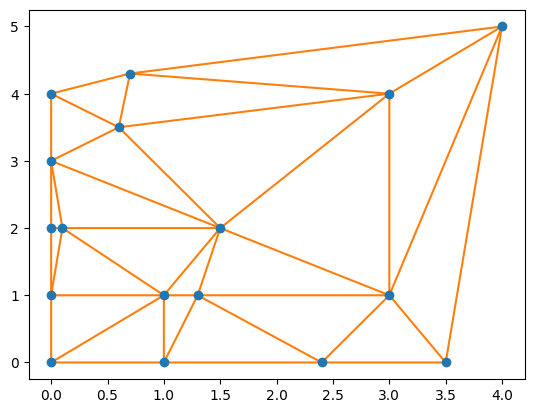

In [118]:
import numpy as np
import matplotlib.pyplot as plt

# Play around with adding or taking away points to see how the resulting plot changes:
points = np.array([[0,0],[0,1],[0,2],[0,3],[0,4],[0.1,2],[1,1],[1.5,2],[1.3,1],[4,5],[3,4],[3,1],[0.6,3.5], [3.5,0], [1,0],[2.4,0],[0.7,4.3]])
# points = np.array([[0, 0], [0, 1.1], [1, 0], [1, 1]])
from scipy.spatial import Delaunay

# Computing the triangles (Delaunay triangulation of our data)
tri = Delaunay(points)

# Plotting our points
plt.plot(points[:,0], points[:,1], 'o')

# Plotting our triangles
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.show()

After this, to interpolate a given point in our grid LinearNDInterpolator:
- Determines which triangle it is in, say it's in the triangle with vertices $v_1,v_2,v_3$.
- Writes the point's position as $a_1 v_1 + a_2 v_2 + a_3 v_3$ where $a_i>0$ for all $i$ and $\sum_i a_i = 1$.
- Gives an interpolated value of $\sum_i a_i f(v_i)$. (In our case the weighted sum of the implied volatilities of the 3 vertex points).

In [119]:
# Sort the data by strike then by DTE to order our values
valid_options.sort_values(by=["strike","DTE"],inplace=True)

In [120]:
# Now pass our data (in the correct format) into SciPys LinearNDInterpolator
from scipy.interpolate import LinearNDInterpolator
plotted_options = valid_options.tail(-1) # Ignoring the first one as it's very large, and makes it difficult to see the other points.

# Initialising our linear interpolator
lin_interpolator = LinearNDInterpolator(list(zip(plotted_options["strike"],plotted_options["DTE"])), plotted_options["IV"])

# Making grid of points we'll evaluate our interpolation function on
strike_vec = np.linspace(min(plotted_options["strike"]), max(plotted_options["strike"]))
DTE_vec = np.linspace(min(plotted_options["DTE"]), max(plotted_options["DTE"]))

X,Y = np.meshgrid(strike_vec,DTE_vec) # Standard function that forms a 2D grid from the linspaces we've just created

# Using the linear interpolator to get values
IV_vals = lin_interpolator(X,Y)

In [121]:
fig = go.Figure(data = [go.Surface(x=strike_vec, y=DTE_vec, z=IV_vals, colorscale = "Blues", surfacecolor=IV_vals)])
fig.update_layout(title = f"Linearly interpolated volatility surface for {ticker}", autosize = False,
                  width = 600, height= 600,
                  margin = dict(l=50, r=50, t=90, b=50))
fig.update_scenes(zaxis_title_text = "Implied Volatility")
fig.show()

### 5.2.2 - Cubic spline interpolation
Next, one of the most common methods to interpolate over implied volatility surfaces. This results in (sometimes) slightly smoother plots, but similar to linear interpolation, it does not prevent arbitrage opportunities. We will use CloughTocher2DInterpolator which constructs a continuously differentiable piecewise cubic interpolator. Just like in LinearNDInterpolator, it first triangulates the data. Then, it uses piecewise cubic polynomials on each triangle (determined with a Clough Toucher scheme). Cubic functions are always continuously differentiable, but at the boundaries (edges of triangles) they may not be. The method forces points on these edges to also be continuously differentiable.

The method tries to minimize curvature of the resulting surface (there are multiple ways to fit a cubic, and we take the one that's "smoothest" in the sense of minimal curvature). For a more thorough description, see the papers linked from [this SciPy page](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CloughTocher2DInterpolator.html).

Exercise 5: Using the linear interpolation code above as a template, create the same plot but using CloughTocher for cubic spline interpolation instead of linear interpolation. Also:
- Set colorscale to be "RdBu".
- Flip the way colors are applied by changing the value surfacecolor is set to.
- Add a title and axis labels.

In [124]:
from scipy.interpolate import CloughTocher2DInterpolator
import plotly.graph_objects as go
import numpy as np

# Aseguramos que los datos están ordenados
valid_options.sort_values(by=["strike", "DTE"], inplace=True)
plotted_options = valid_options.tail(-1)

# 1. Inicializar el interpolador cúbico
ct_interpolator = CloughTocher2DInterpolator(list(zip(plotted_options["strike"], plotted_options["DTE"])), plotted_options["IV"])

# 2. Crear la malla
strike_vec = np.linspace(min(plotted_options["strike"]), max(plotted_options["strike"]))
DTE_vec = np.linspace(min(plotted_options["DTE"]), max(plotted_options["DTE"]))
X, Y = np.meshgrid(strike_vec, DTE_vec)

# 3. Calcular los valores interpolados y guardarlos como 'cubic_IV_vals'
# CAMBIO IMPORTANTE AQUÍ:
cubic_IV_vals = ct_interpolator(X, Y)

# 4. Graficar usando la nueva variable
fig = go.Figure(data=[go.Surface(x=strike_vec,
                                 y=DTE_vec,
                                 z=cubic_IV_vals,  # Usamos cubic_IV_vals
                                 colorscale="RdBu",
                                 surfacecolor=-cubic_IV_vals)]) # Usamos cubic_IV_vals

fig.update_layout(title=f"Cubic Spline (CloughTocher) Volatility Surface for {ticker}",
                  scene = dict(
                    xaxis_title='Strike Price',
                    yaxis_title='Days to Expiration (DTE)',
                    zaxis_title='Implied Volatility'
                  ),
                  autosize=False,
                  width=600, height=600,
                  margin=dict(l=50, r=50, t=90, b=50))

fig.show()

## 5.3 - Aesthetic changes (Optional)
This section has no real practical applications, but for those interested in making their volatility surfaces look prettier, we will discuss some modifications one can make to improve the look of the plotly plots.

One can change the colour to look like the typical volatility surfaces you see on google using colorscale = "Jet" instead of "RdBu" or "Blues". Another commonly seen feature on volatility surfaces is a grid. We can include this in plotly fairly easily.

Exercise 6:

In [125]:
import plotly.graph_objects as go
import numpy as np

fig = go.Figure(data=[go.Surface(x=strike_vec,
                                 y=DTE_vec,
                                 z=cubic_IV_vals,
                                 colorscale="Jet",
                                 surfacecolor=cubic_IV_vals)])

fig.update_layout(title="Cubic Spline Volatility Surface with Grid",
                  autosize=False,
                  width=800, height=800,
                  margin=dict(l=50, r=50, t=90, b=50),
                  scene=dict(
                      xaxis_title='Strike Price',
                      yaxis_title='Time to Expiry (DTE)',
                      zaxis_title='Implied Volatility'
                  ))

X_rev, Y_rev = np.meshgrid(DTE_vec, strike_vec)

line_marker = dict(color="black", width=2)

for x, y, z in zip(X, Y, cubic_IV_vals):
    fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode="lines", line=line_marker, showlegend=False))
for x, y, z in zip(X_rev, Y_rev, cubic_IV_vals.T):
    fig.add_trace(go.Scatter3d(x=y, y=x, z=z, mode="lines", line=line_marker, showlegend=False))

fig.show()

## 5.4 - Other plotting considerations:
We can see even from a brief look at the plots that these implied volatility surfaces are very rough. This isn't necessarly a problem, as the arbitrage conditions regarding convexity and monotonicity we've stated only apply to the prices. However, these very rough surfaces may be an indication that the prices this surface would give may have arbitrage opportunities (both butterfly arbitrage and calendar arbitrage seem to be present). Furthermore, this isn't an artefact of some inaccuracy in our IV computation as the same behaviour appears when using yfinance's computed IVs (you can quite easily modify the above to check this for yourself).

All hope is not lost. There are many other things one may wish to consider when producing sensible volatility surface plots to lower the chances of arbitrage opportunities and inaccuracies even when using a method that doesn't guarantee an arbitrage-free surface. Some things to think about include:
- Data quality in financial markets is imperfect and when data is missing we will sometimes get prices of 0 for the bid/ask/current price (which are clearly incorrect). This will wreak havoc on the model if they aren't checked and protected against. At the moment we default to the last traded price in these situations.
- The recency of data can have a big impact. In some cases the most recent price is quite old and would no longer be a sensible price (i.e. the underlying has changed value significantly since then). Furthermore, sometimes options are traded on a market with different trading times to that of the underlying, which can lead to prices for one being more recent than the other and making our implied volatilities incorrect.
- There are several options for which prices to use. One can use the bid, the ask, the midpoint of the bid and the ask and (for more liquid markets) the most recent price. One may also want to include information about the size of the spread as this is very important when considering arbitrage opportunities (even if a theoretical arbitrage may exist, if the spread is large it will not be profitable).
- If one uses the midpoint (as we have) it is  possible for there to be no arbitrage in the real market but an arbitrage opportunity may appear to exist when one looks only at the midpoints. For this reason it can make sense to ignore prices where the spread is particularly large.
- Similarly, out of date / incorrect option prices can lead to non monotonic prices as the strike/time to maturity changes (which is again quite problematic, as it also creates arbitrage opportunities)
- Some exchanges (For instance ICE, EUREX) send settlement prices - the price at which trading the asset closes / was last traded for. If they haven't had a trade in a few days, they may still provide a settlement price which is far from the trading price of similar options and would lead to an arbitrage if included.
- Using primarly out of the money options - If one uses in the money options, these have generally higher prices and larger spreads (making the bid vs midpoint vs ask vs most recent traded price choice much more impactful). We can see in some places our implied volatilities seem to be changing rapidly for different strike prices. One plausible reason for this is that some strike prices have call option data while others have puts, so when either the call or put prices are inaccurate, we get these poorly behaved oscillations.

One possible extension activity would be use the above ideas and explore filtering which options are used to make our volatility surfaces in order to improve our results.

# 6 - Volatility Surface terms and properties
Some specific slices of the volatility surface are important enough in trading to have their own names and many volatility strategies may use only one aspect to determine the profitability of trades. We will also discuss some typical types of volatility surfaces and some typical behaviours.

## 6.1 - Volatility Skew
Volatility skew is the general term for the shape of the cross section of the volatility surface with a fixed time to expiry (strikes varying). Typically the words "Volatility skew" (also "negative skew" or "reverse skew") on their own refer to the case where we have higher implied volatilities for low strike prices than for high strike prices. The most common reason for this that investors are willing to pay a premium for put options to protect against large market crashes. Some trading strategies (including one that was in a coding session last year called VolatilityRiskPremium) involve selling these puts to take advantage of this premium as the strategies suppose that investors are overpaying out of fear of a big crash.


### 6.1.1 - Positive / forward skew
Another type of volatility skew is positive / forward skew. This, as you would expect, is the opposite of negative / reverse skew. Implied volatility for high strikes is higher than it is for low strikes. This suggests market participants are expecting a fairly sharp increase in prices, and are willing to pay a little bit extra to make a profit off of the increase. Positive skew is commonly found in commodities like gold and oil. One reason for this with gold and other "safe haven" assets is that in market crashes, people tend to buy gold and other precious metals. Oil, as well as other commodities that are needed to make other products, can have sudden demand surges where lots of people need them causing prices to rise suddenly which can also lead to positive skew.

### 6.1.2 - Flat / no skew
This refers to when the implied volatility is (roughly) the same across options. In these cases, investors expectations of future returns perfectly match the log-normal distribution that the Black-Scholes model predicts. This doessn't, however, mean that the volatility is similar to historical levels. Often changes in the overall height of the volatility surface can be as important as the shape.

### 6.1.3 - Volatility smiles
One common shape for the volatility skew to take is a "smile", with higher implied volatilities further from the strike price and lower implied volatilities closer to the strike. There are several plausible explanations for volatility smiles, including:
- Demand is higher for in / out of the money options than at (or near) the money ones, so they're more expensive and therefore have a higher implied volatility.
- Market participants expect a higher probability of "rare" market events (i.e. future stock prices follow a platykurtic distribution, a one with thinner tails than a normal distribution). Many modern option pricing models predict the true chances of "rare" market events as higher than that of Black-Scholes. They therefore have different (larger) estimates of the changes of a massive increase / decrease in price than the Black-Scholes model predicts leading to higher implied volatilities.

One piece of evidence supporting the "market participants expect a higher probability of rare events" hypothesis is that before the 1987 crash, volatility surfaces were much flatter. After 1987, market participants realised that these "rare" events were much more common than the Black-Scholes model would predict and implied volatilities far from the strike increased.

Some research also suggests there is a relationship between how "strong" / curved the volatility smirk is and the future performance of the underlying. Also, if investors expect the underlying to perform poorly, they may buy OTM puts for downside protection (increasing the implied volatility for low strikes) and if they expect the underlying to perform well, they may buy OTM calls. Hence, the current volatility surface can give some indications of expected future performance.

### 6.1.4 - Inverted volatility smiles
In some (generally rarer) cases, implied volatility can be highest near the money and lower far from the money, leading to an "inverted smile" (or frown, but inverted smile is the more common term). There are some meaningful reasons for this:
- Market participants expect a lower probability of "rare" market events (i.e. future stock prices follow a platykurtic distribution, a one with thinner tails than a normal distribution)
- When a significant jump in stock price is likely to occur at a predictable time, inverted volatility smiles tend to occur. This is because the probability the stock being near its current price in the future is low, and it is more likely to be further from the current strike. Some real world examples of this include:
    - When a pharmaceutical company has a drug that's about to finish the last clinical trial (if successful, the share price increases massively, if unsuccessful, the share price decreases massively)
    - When a large tech company is about to release an earnings report (if the earnings are good the price will jump up, if poor it will fall rapidly)
    - For large sectors of the market: when a large election (i.e. for the US president) is about to take place between candidates with very different views (i.e. one will bring harsh regulation and higher taxes, while the other promises deregulation and tax cuts)
    - For large sectors of the market: When the Federal Open Market Committee is about to release the interest rate announcement for the coming months
There are models devoted to determining sensible options prices prior to earnings announcements (and other big shifts of this nature). For instance [this paper](https://business.columbia.edu/sites/default/files-efs/pubfiles/6051/DJ_2006.pdf) discusses the improvements that can be made when one takes into account earnings announcements.

More generally, jump diffusion models are used to get better prices for options both in cases of inverted volatility smiles and more generally. There are a range of different jump diffusion models and many involve too much stochastic calculus to be included here. For a more detailed review of jump diffusion models, see [this paper](https://www.columbia.edu/~sk75/MagSci02.pdf).


## 6.2 - Volatility term structure
This refers to how the implied volatility changes for different times to expiry with the same strike price. These can change based on lots of important information in the markets. For instance, the impact of a successful or failing drug trial can lead to higher implied volatility on options just after the trial than just before. Generally options expiring just after the event have a larger change in implied volatility than those expiring much later than the event. Several events can cause increases in implied volatility observable in the term structure including:
- US Treasury bills have increased volatlity just before short-term interest rates are announced
- Commodities like corn show increased volatility prior to the announcement of harvest forecasts

Volatility term structures can more generally be:
- increasing, so the market expects higher volatility far in the future than in the short term
- decreasing, the market exprects lower volatility far in the future than in the short term

In practice, the term structures are rarely truly monotonic, and whether a term structure is increasing or decreasing is determined by the general pattern.

Some reasons for increasing volatility term structures include future supply disruptions (i.e. if there's an expectation of a large war in a couple months, and in this war one of the participants is a major oil exporter, the volatility of oil prices will be much higher in the future than tomorrow).

Far in the future implied volatilities are generally fairly similar to historic volatilities. One possible reason behind this gradual return to a more "normal" lower volatility is said to be because a stock cannot have extremely high volatility for a long time, and must eventually revert to it's historical mean. Therefore, if the current short term implied volatility is particularly high then the long term volatility should be lower than the short term and we get a decreasing implied volatility.


### 6.2.1 - Volatility structuce in trading strategies

The volatility term structure can be used to predict returns of stocks. For instance in [this paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1944298) a clear relationship is seen between the slope of the volatility term structure and future stock returns (although when implemented in practice, this may be significantly less profitable with all of the fees). We may look at this strategy in more detail in the session where we go through this document.

# 7 - Extension activities
We will now discuss some extension activities one can do to improve on our above work by:
- Improving the performance
- Improving the accuracy of our end results
- Exploring other models with practical value in other contexts

As we will have limited time in the session, and some extensions are open ended and complex, we will focus on a select few for the session. You are free to attempt whichever extensions you wish, but only the first section will be covered in detail.


## 7.1 - Extensions for the session
The following extension activities are entirely optional. If there is enough time in the session, we may go through some or all of them:
- Filtering the options based on (some of) the criterion stated just after the last volatility surface plot. (See also: [this page on building reasonable volatility surfaces](https://tsimagine.com/insights/thinking-about-building-a-volatility-surface-think-again/)). This will hopefully make the plots look more reasonable, and reduce the chances of arbitrages occurring in our surfaces.
- Faster IV computations - it takes some time to compute IVs, so performance improvements would be worthwhile:
    - Experimenting with faster normal CDF computations (for instance, using some of the ideas covered in this paper: [Approximating the cumulative distribution function of the normal distribution](http://jsr.isrt.ac.bd/wp-content/uploads/41n1_5.pdf)).
    - Implementing the Hybrid Newton method for root finding discussed just before we implemented the Brent method, which is useful for implied volatilities as we have a closed form expression for the derivative.
- Different pricing models:
    - One alternative to the Black-Scholes model is the Bachelier model. This model assumes S_t is a normally distributed variable instead of a log-normally distributed one which leads to the possibility of prices being negative! This is generally seen as a downside, since stocks shouldn't have negative values. However, in 2020 oil prices dropped so sharply that for a time they were negative, and at that time some exchanges swapped to the Bachelier implied volatility instead of the Black-Scholes implied volatility. Fortunately, the Bachelier IV can be computed very quickly without an iterative algorithm. A great paper for further reading on the Bachelier model is this: [A Black-Scholes user's guide to the Bachelier model](https://arxiv.org/abs/2104.08686). It should have all the information you need to understand the model and to make a Bachelier volatility surface (as well as much more).

## 7.2 - Bonus extensions
There are also some other extensions we think may be interesting to try out in your own time, but would take too much time to properly address in the session. If you do any of these we'd greatly appreciate updates on how they went:
- Modelling Volatility surfaces:
    - Implementing the SVI model discussed previously. The original SVI model paper is [Arbitrage-free SVI volatility surfaces](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2033323). There's also a very impressive Masters Thesis that explains the SVI model and some extensions to it: [The SVI implied volatility model and its calibration](https://kth.diva-portal.org/smash/get/diva2:744907/FULLTEXT02.pdf). Links to papers on some extensions (SSVI, eSSVI) can be found in the references.
    - Using VAEs to estimate / interpolate over the missing regions of the volatility surface. A company that makes valuation and risk management tools, Riskfuel Analytics, uses (or once used) variational autoencoders to quickly determine volatility surfaces for different assets. More details can be found in this paper: [Variational Autoencoders: A Hands-Off Approach to Volatility](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2033323)
    - Some other approaches try to model the probability density of the time T price of the underlying. A method from this paper: [Option-based Equity Risk Premiums](https://arxiv.org/pdf/1910.14522) suggests the use of Gaussian Mixture Models for the underlying, fitting these models so the resulting density matches the implied volatilities observed. One can then easily compute the rest of the volatility surface using the pdf of the underlying.
    - [Kriging the Local Volatility Surface](https://www.bayes.city.ac.uk/__data/assets/pdf_file/0010/640477/SIFIN_Option_Pricing.pdf) describes a Kriging based volatility surface interpolation method. This method allows for no-arbitrage constraints and can be evaluated relatively quickly.
    - For interest, this paper has a comparison of many different volatility surface construction methods' performance on a large dataset of options prices: [Implied volatility surfaces: a comprehensive analysis using half a billion option prices](https://link.springer.com/article/10.1007/s11147-023-09195-5)
- Even faster IV computations:
    - This paper by Peter Jaeckel is slightly outdated, but has a much faster method of computing the implied volatility than ours: [By Implication](http://www.jaeckel.org/ByImplication.pdf)
    - This paper has a more modern (and faster) method of computing the implied volatility: [Let's be rational](http://www.jaeckel.org/LetsBeRational.pdf)
- Trading strategies:
    - Another extension is to implement the volatility term structure trading strategy mentioned above. A paper that implements this can be found here: [Equity Volatility Term Structures and the Cross-Section of Option Returns](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1944298)
    - You could also look into a strategy which makes use of the full volatility surface instead of only the volatility term structure for a fixed strike or the volatility skew for a single maturity date. An example is this paper: [Risk-Neutral Skewness and Stock Outperformance](https://wp.lancs.ac.uk/fofi2018/files/2018/03/FoFI-2017-0020-Konstantinos-Gkionis.pdf) which uses Risk-Neutral Skewness, a measure computed from implied volatilities to generate returns.

# 8 - Volatility Surfaces in Algorithmic Trading Strategies
In the session, we'll go through some possible applications of the volatility surface for trading strategies. One thing to think about is the following strategy:
- In many aspects of finance we see mean reversion, particularly over longer periods
- We can compute the long term mean volatility based on historical realised volatility
- For a given option, we can then compare this to the current implied volatility:
    - If the implied volatility is much higher, we sell the option as it's overpriced relative to historical volatility, and we predict the volatility will revert to the mean.
    - If the implied volatility is much lower, we buy the option as it's underpriced relative to historical volatility, and we predict the volatility will revert to the mean.

How do you think this strategy would perform?


# 9 - References:
1. General information:
    - Cambridge Stochastic Financial Models Lecture Notes - James Norris, 2019. https://www.statslab.cam.ac.uk/~james/Lectures/sfm.pdf
    - A review on Implied volatility calculation - Giuseppe Orlando, Giovanni Taglialatela, 2017. https://www.sciencedirect.com/science/article/pii/S0377042717300602
    - By Implication - Peter Jaeckel, 2010. http://www.jaeckel.org/ByImplication.pdf
2. What is the volatility surface:
    - Implied volatility explanation: How Implied Volatility (IV) Works With Options and Examples - Akhilesh Ganti, 2024. https://www.investopedia.com/terms/i/iv.asp
    - Volatility surface explanation: The Volatlity Surface explained - Craig Anthony, 2023. https://www.investopedia.com/articles/stock-analysis/081916/volatility-surface-explained.asp
    - Historical Volatility Calculation - https://www.investopedia.com/articles/stock-analysis/081916/volatility-surface-explained.asp
3. Getting options chains data:
    - Getting options with yfinance - 2023. https://www.fintut.com/yahoo-finance-options-python/
4. Computing the implied volatility:
    - Algebraic approximations of implied volatility: A new formula for computing implied volatility - Steven Li, 2005. https://www.fintut.com/yahoo-finance-options-python/
    - Bisection method (with code): Python Numerical Methods Chapter 19 Section 3 - Bisection Method - Qingkai Kong, Timmy Siauw, Alexandre Bayen, 2020. https://pythonnumericalmethods.studentorg.berkeley.edu/notebooks/chapter19.03-Bisection-Method.html
    - Newton-Raphson method (with code): Python Numerical Methods Chapter 19 Secton 4 - Newton-Raphson Method - Qingkai Kong, Timmy Siauw, Alexandre Bayen, 2020. https://pythonnumericalmethods.studentorg.berkeley.edu/notebooks/chapter19.04-Newton-Raphson-Method.html
    - Hybrid Newton-Bisection method: Numerical Recipes in C Section 9.4 (page 362) - William H. Press, Saul A. Teukolsky, William T. Vetterling, Brian P. Flannery, 2002. https://www.grad.hr/nastava/gs/prg/NumericalRecipesinC.pdf
    - Brent's method: An algorithm with guaranteed convergence for finding a zero of a function - R. P. Brent, 1971. https://maths-people.anu.edu.au/~brent/pd/rpb005.pdf
    - Secant method - BYJU'S. https://byjus.com/maths/secant-method/
    - Inverse quadratic interpolation - In a nutshell: Inverse quadratic interpolation - Douglas Wilhelm Harder, 2023. https://ece.uwaterloo.ca/~dwharder/nm/Lecture_materials/pdfs/6.2.6%20Inverse%20quadratic%20interpolation%20in%20a%20nutshell.pdf
    - Plotly 3D scatter plot documentation - https://plotly.com/python/3d-scatter-plots/
5. Interpolating and Plotting the volatility surface:
    - Calendar arbitrage example question - Gordon, 2016. https://quant.stackexchange.com/questions/15215/how-to-exploit-calendar-arbitrage
    - The SVI model - Arbitrage Free SVI Volatility Surfaces - Jim Gatheral, Antoine (Jack) Jacquier, 2013. https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2033323
    - Arbitrage in SVI model - Arbitrage Free Implied Volatility Surfaces - Michael Roper, 2010. https://talus.maths.usyd.edu.au/u/pubs/publist/preprints/2010/roper-9.pdf
    - Bilinear interpolation - https://en.wikipedia.org/wiki/Bilinear_interpolation
    - Visualising Delaunay Triangulation - Ian Henry, 2022. https://ianthehenry.com/posts/delaunay/
    - Linear interpolation with Barycentric coordinates: Barycentric interpolation: fast interpolation on arbitrary grids - Simon Barthelme, 2013. https://dahtah.wordpress.com/2013/03/06/barycentric-interpolation-fast-interpolation-on-arbitrary-grids/
    - Plotly 3D surface plot documentation - https://plotly.com/python/3d-scatter-plots/
    - CloughTocher2DInterpolator - SciPy documentation, https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CloughTocher2DInterpolator.html
    - Considerations for building a volatility surface: Thinking About Building a Volatility Surface? Think Again. - TS Imagine team, https://tsimagine.com/insights/thinking-about-building-a-volatility-surface-think-again/
6. Volatility surface terms and properties:
    - Volatility Skew: How it Can Signal Market Sentiment - Will Kenton, 2023. https://www.investopedia.com/terms/v/volatility-skew.asp
    - What Is a Volatility Smile and What Does It Tell Options Traders? - Cory Mitchell, 2021. https://www.investopedia.com/terms/v/volatilitysmile.asp
    - Link between a risky future event and inverted volatility smiles: Pricing Event Risk: Evidence from Concave
Implied Volatility Curves - Lykourgos Alexiou, Amit Goyal, Alexandros Kostakis, Leonidas Rompolis, 2021. https://www.efmaefm.org/0EFMAMEETINGS/EFMA%20ANNUAL%20MEETINGS/2022-Rome/papers/EFMA%202022_stage-3032_question-Full%20Paper_id-108.pdf
    - Term structure of Implied Volatility - Martin Noel, 2017. https://www.optionmatters.ca/term-structure-implied-volatility/
    - Relationship between volatility term structure slope and returns: Aurelio Vasquez, 2011. https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1944298
7. Extensions:
    - Considerations for building a volatility surface: Thinking About Building a Volatility Surface? Think Again. - TS Imagine team, https://tsimagine.com/insights/thinking-about-building-a-volatility-surface-think-again/
    - Approximting the Cumulative Distribution Function of the Normal Distribution - Amit Choudhury, Subhasis Ray, Pradipta Sarkar, 2007. http://jsr.isrt.ac.bd/wp-content/uploads/41n1_5.pdf
    - A Black-Scholes user's guide to the Bachelier model - Jaehyuk Choi, Minsuk Kwak, Chyng Wen Tee, Yumeng Wang, 2021. https://arxiv.org/abs/2104.08686
    - The SVI model - Arbitrage Free SVI Volatility Surfaces - Jim Gatheral, Antoine (Jack) Jacquier, 2013. https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2033323. Presentation version: https://mfe.baruch.cuny.edu/wp-content/uploads/2013/01/OsakaSVI2012.pdf
    - Thesis on fitting the SVI model: The SVI implied volatility model and its calibration - Alexander Aurell, 2014. https://kth.diva-portal.org/smash/get/diva2:744907/FULLTEXT02.pdf
    - A follow up to the SVI introducing an arbitrage free version, the Surface SVI (SSVI): Arbitrage-Free SVI Volatility Surfaces - Jim Gatheral, Antoine (Jack) Jacquier, 2014. https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2033323
    - An advancement on the SSVI paper: The Extended SSVI Volatility surface - Sebas Hendriks, Claude Martini, 2017. https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2971502
    - VAEs for volatility surfaces: Variational Autoencoders: A Hands-Off Approach to Volatility - Maxime Bergeron, Nicholas Fung, John Hull, Zissis Poulos, 2021. https://arxiv.org/abs/2102.03945
    - GMMs for volatility surface modelling: Option-based Equity Risk Premiums - Alan Lewis, 2020. https://arxiv.org/abs/1910.14522
    - (Slides on) Kriging the Local Volatility Surface - Matthew Dixon, 2021. https://www.bayes.city.ac.uk/__data/assets/pdf_file/0010/640477/SIFIN_Option_Pricing.pdf
    - Comparing volatility surface models: Implied volatility surfaces: a comprehensive analysis using half a billion option prices - Maxim Ulrich, Lukas Zimmer, Constantin Merbecks, 2023. https://link.springer.com/article/10.1007/s11147-023-09195-5
    - A fast approach to implied volatility computations: By Implication - Peter Jaeckel, 2010. http://www.jaeckel.org/ByImplication.pdf
    - An even more modern approach: Let's be rational - Peter Jaeckel, 2016. http://www.jaeckel.org/LetsBeRational.pdf
    - Equity Volatility Term Structures and the Cross-Section of Option Returns - Aurelio Vasquez, 2015. https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1944298
    - Risk-Neutral Skewness and Stock Outperformance, Konstantinos Gkionis, Alexandros Kostakis, George Skiadopoulos, Przemyslaw S. Stilger, 2017. https://wp.lancs.ac.uk/fofi2018/files/2018/03/FoFI-2017-0020-Konstantinos-Gkionis.pdf